ZVAR Data Analysis Notebook

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import glob as glob
import fpw
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from scipy.stats import median_abs_deviation
from astropy.timeseries import LombScargle
from penquins import Kowalski
import json
import h5py
from datetime import datetime
import time as tme
import os
from astropy.table import Table
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

credentials = "/data/swhitebook/passwd.json"

with open(credentials) as f:
    passwd = json.load(f)

username = passwd["melman"]["username"]
password = passwd["melman"]["password"]

k = Kowalski(
    protocol="https",
    host="melman.caltech.edu",
    port=443,
    username=username,
    password=password,
    verbose=False,
    timeout=600,
)

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VariabilityCandidate:
    def __init__(self, psid, ra, dec, valid, freq, fap, best_M, gaia_G, gaia_BP, gaia_RP, gaia_parallax, gaia_MG, gaia_BP_RP):
        self.id = psid
        self.ra = ra
        self.dec = dec
        self.valid = valid
        self.freq = freq
        self.fap = fap
        self.best_M = best_M
        self.gaia_G = gaia_G
        self.gaia_BP = gaia_BP
        self.gaia_RP = gaia_RP
        self.gaia_parallax = gaia_parallax
        self.gaia_MG = gaia_MG
        self.gaia_BP_RP = gaia_BP_RP


def process_curve(ra, dec, times, mags, magerrs):
    times = np.array(times)
    mags = np.array(mags)
    magerrs = np.array(magerrs)

    valid_indices = ~np.isnan(times)
    times = times[valid_indices]
    mags = mags[valid_indices]
    magerrs = magerrs[valid_indices]

    skycoord = coord.SkyCoord(ra, dec,
                            unit=(u.deg, u.deg), frame='icrs')
    palomar = coord.EarthLocation.of_site('Palomar')
    times = time.Time(np.array(times), format='mjd', scale='utc', location=palomar)
    ltt_bary = times.light_travel_time(skycoord) #Calculate light travel time
    barycorr_times = (times.tdb + ltt_bary).value #Add on the light travel time
    barycorr_times = barycorr_times - 2400000.5 #Convert from JD to BJD
    barycorr_times *= 86400 #Convert from BJD to BJS
    barycorr_times += 15 #midpoint correct ZTF timestamps
    barycorr_times -= np.min(barycorr_times) #Subtract off the zero point (ephemeris may be added later)

    #Convert mags to flux values
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    med_mag = np.median(mags)

    flux = 10**(0.4*(med_mag - mags)) - 1.0
    ferrs = magerrs/1.086

    #Set nan values to zero
    flux[np.isnan(flux)] = 0
    ferrs[flux == 0] = np.inf
    
    #Basic MAD clip
    valid = np.where(np.abs(flux) < 5 * 1.483 * median_abs_deviation(flux))

    barycorr_times = barycorr_times[valid]
    flux = flux[valid]
    ferrs = ferrs[valid]

    flux -= np.mean(flux)

    return barycorr_times, flux, ferrs


def remove_deep_drilling(barycorr_times, flux, ferrs):
    dt = 40.0  # seconds
    znew_times, znew_flux, znew_ferrs = [], [], []

    unique_days = np.unique(np.floor(barycorr_times / 86400.0))
    for ud in unique_days:
        mask = (barycorr_times > ud * 86400.0) & (barycorr_times < (ud + 1.0) * 86400.0)
        zday_times = barycorr_times[mask]
        zday_flux = flux[mask]
        zday_ferrs = ferrs[mask]
        Nz = len(zday_times)

        # If more than 10 exposures in a night, check time sampling
        if Nz > 10:
            tsec = zday_times
            zdiff = ((tsec[1:] - tsec[:-1]) < dt)

            # Handle some edge cases
            if zdiff[0]:
                zdiff = np.insert(zdiff, 0, True)
            else:
                zdiff = np.insert(zdiff, 0, False)
            for j in range(1, len(zdiff)):
                if zdiff[j]:
                    zdiff[j - 1] = True

            # Only keep exposures with sampling > dt
            znew_times.append(zday_times[~zdiff])
            znew_flux.append(zday_flux[~zdiff])
            znew_ferrs.append(zday_ferrs[~zdiff])
        else:
            znew_times.append(zday_times)
            znew_flux.append(zday_flux)
            znew_ferrs.append(zday_ferrs)

    znew_times = np.concatenate(znew_times)
    znew_flux = np.concatenate(znew_flux)
    znew_ferrs = np.concatenate(znew_ferrs)

    return znew_times, znew_flux, znew_ferrs


def query_kowalski(k, ra, dec, min_epochs=50):
    query = {
        "query_type": "cone_search",
        "query": {
            "object_coordinates": {
                "cone_search_radius": 5,
                "cone_search_unit": "arcsec",
                "radec": {
                    'object': [
                        ra,
                        dec
                    ]
                }
            },
            "catalogs": {
                "ZTF_sources_20240117": {
                    "filter": {},
                    "projection": {
                        'data.hjd': 1,
                        'data.mag': 1,
                        'data.magerr': 1,
                        'data.ra': 1,
                        'data.dec': 1,
                        'data.fid': 1,
                        'data.programid': 1,
                        'data.catflags': 1,
                        'filter':1
                    }
                }
            }
        },
        "kwargs": {
            "filter_first": False
        }
    }

    start = tme.time()
    response = k.query(query=query)
    end = tme.time()
    data = response["default"].get("data")

    key = list(data.keys())[0]
    data = data[key]
    key = list(data.keys())[0]
    data = data[key]
    lightcurves = {}
    num_epochs = 0
    for datlist in data:
        objid = str(datlist["_id"])
        # print(datlist)
        ztf_filter = datlist["filter"]
        dat = datlist["data"]
        hjd, mag, magerr, coords_out, ztf_id, ztf_filt = [], [], [], [], [], []
        for dic in dat:
            if dic["catflags"]==0:
                hjd.append(dic["hjd"])
                mag.append(dic["mag"])
                magerr.append(dic["magerr"])
            coords_out.append(dic["ra"])
            coords_out.append(dic["dec"])
            ztf_id.append(objid)
            ztf_filt.append(ztf_filter)
        if len(hjd) < min_epochs: continue
        if len(hjd) > num_epochs:
            num_epochs = len(hjd)
            lightcurves["hjd"] = np.array(hjd)
            lightcurves["mag"] = np.array(mag)
            lightcurves["magerr"] = np.array(magerr)
            lightcurves["coords"] = np.array(coords_out)
            lightcurves['objid'] = objid
            lightcurves['filter'] = ztf_filter

        barycorr_times, flux, ferrs = process_curve(ra, dec, lightcurves['hjd'], lightcurves['mag'], lightcurves['magerr'])
        barycorr_times, flux, ferrs = remove_deep_drilling(barycorr_times, flux, ferrs)

        return barycorr_times, flux, ferrs


def freq_grid(t, fmin=None, fmax=None, oversample=3):
    trange = max(t) - min(t)
    texp = np.nanmin(np.diff(np.sort(t)))
    fres = 1./trange/oversample
    if fmax is None:
        fmax = 0.5 / texp
    if fmin is None:
        fmin = fres
    fgrid = np.arange(fmin,fmax,fres)
    return fgrid

def flag_terrestrial_freq(frequencies):
    """
    Function to identify and flag terrestrial frequencies
    from an array of frequency values.

    frequencies = numpy array of frequencies in Hz
    """
    # Define some standard frequencies in terms of Hz
    f_year = 0.002737803 / 86400  # Sidereal year (365.256363 days)
    f_lunar = 0.036600996 / 86400  # Lunar sidereal month (27.321661 days)
    f_day = 1.00273719 / 86400  # Sidereal day (23.9344696 hours)

    # List of frequency/width pairs indicating the
    # regions to be excluded from the frequencies array
    ef = np.array([
        (f_year, 0.00025 / 86400),  # 1 year
        (f_year / 2, 0.000125 / 86400),  # 2 year
        (f_year / 3, 0.0000835 / 86400),  # 3 year
        (f_year / 4, 0.0000625 / 86400),  # 4 year
        (f_year / 5, 0.0000500 / 86400),  # 5 year
        (f_year * 2, 0.00025 / 86400),  # 1/2 year
        (f_year * 3, 0.00025 / 86400),  # 1/3 year
        (f_year * 4, 0.00025 / 86400),  # 1/4 year
        (f_lunar, 0.005 / 86400),  # 1 lunar month
        (f_day, 0.05 / 86400),  # 1 day
        (f_day / 2, 0.02 / 86400),  # 2 day
        (f_day / 3, 0.01 / 86400),  # 3 day
        (f_day * 2, 0.05 / 86400),  # 1/2 day
        (f_day * 3, 0.05 / 86400),  # 1/3 day
        (f_day * 3 / 2, 0.02 / 86400),  # 2/3 day
        (f_day * 4 / 3, 0.02 / 86400),  # 3/4 day
        (f_day * 5 / 2, 0.02 / 86400),  # 2/5 day
        (f_day * 7 / 2, 0.02 / 86400),  # 2/7 day
        (f_day * 4, 0.05 / 86400),  # 1/4 day
        (f_day * 5, 0.05 / 86400),  # 1/5 day
        (f_day * 6, 0.05 / 86400),  # 1/6 day
        (f_day * 7, 0.05 / 86400),  # 1/7 day
        (f_day * 8, 0.05 / 86400),  # 1/8 day
        (f_day * 9, 0.05 / 86400),  # 1/9 day
        (f_day * 10, 0.05 / 86400)  # 1/10 day
    ])

    # Create array to store keep/discard indices
    keep_freq = np.ones(len(frequencies), dtype=int)

    # Vectorized operation to flag frequencies
    for center, width in ef:
        mask = (frequencies > center - width) & (frequencies < center + width)
        keep_freq[mask] = 0

    return keep_freq

In [9]:
band = 'r'
cand_files = glob.glob(f'/data/zvar/variability_candidates/0279/*_z{band}.csv', recursive=True)
# cand_files = glob.glob(f'/data/zvar/variability_candidates/0648/*_z{band}.csv', recursive=True)
# cand_files += glob.glob(f'/data/zvar/variability_candidates/0649/*_z{band}.csv', recursive=True)
candidate_list = []
for file in cand_files:
    df = pd.read_csv(file)
    freqs = np.array([df['frequency_20'], df['frequency_10'], df['frequency_5']])
    faps = np.array([df['FAP_20'], df['FAP_10'], df['FAP_5']])
    for i in range(df.shape[0]):
        if df['best_M'][i] == 20:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[0, i], faps[0, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))
        if df['best_M'][i] == 10:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[1, i], faps[1, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))
        if df['best_M'][i] == 5:
            candidate_list.append(VariabilityCandidate(df['psid'][i], df['ra'][i], df['dec'][i], df['valid'][i], freqs[2, i], faps[2, i], df['best_M'][i],
                                                        df['G'][i], df['BP'][i], df['RP'][i], df['parallax'][i], df['MG'][i], df['BP_RP'][i]))

In [4]:
#Load a Gaia HR diagram
gaia_sample = Table.read("hrd_query_edr3_200pc.fits").to_pandas()
gaia_bprp = gaia_sample.phot_bp_mean_mag.values - gaia_sample.phot_rp_mean_mag.values
gaia_gmag = gaia_sample.phot_g_mean_mag.values + 5.0*np.log10(gaia_sample.parallax.values/100)

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


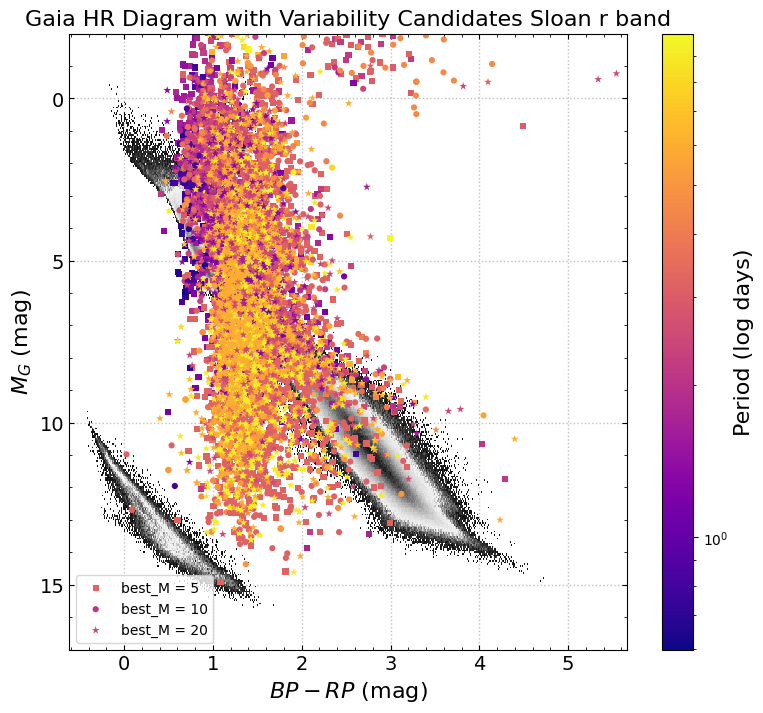

In [5]:
# Assuming candidate_list is already defined and contains the necessary data
periods = [1/candidate.freq for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
bp_rp = [candidate.gaia_BP_RP for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
mg = [candidate.gaia_MG for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]
best_M = [candidate.best_M for candidate in candidate_list if candidate.gaia_BP_RP is not None and candidate.gaia_MG is not None]

# # Filter data to exclude objects with periods within 2 hours of 4 days
# filtered_indices = [i for i, period in enumerate(periods) if not (3.9167 <= period <= 4.0833)]
# periods = [periods[i] for i in filtered_indices]
# bp_rp = [bp_rp[i] for i in filtered_indices]
# mg = [mg[i] for i in filtered_indices]
# best_M = [best_M[i] for i in filtered_indices]

# Overplot candidates on the Gaia HR Diagram
figa = plt.figure('a', figsize=(9, 8))
gs = GridSpec(1, 1)
ax = figa.add_subplot(gs[0])

# Plot 2D-Histogram of 200pc sample
ax.hist2d(
    gaia_bprp, gaia_gmag, cmap='gray',   
    cmin=3,  cmax=30,   vmin=1, vmax=30,  
    bins=(700, 380)
)
ax.hist2d(
    gaia_bprp, gaia_gmag, cmap='gray_r', 
    cmin=30, cmax=1000, vmin=1, vmax=500, 
    bins=(700, 380)
)

# Define marker styles and sizes for different best_M values
marker_styles = {5: ('s', 20), 10: ('o', 20), 20: ('*', 35)}

# Scatter plot for candidates colored by period with logarithmic scale
for m_value in marker_styles:
    indices = [i for i, m in enumerate(best_M) if m == m_value]
    marker, size = marker_styles[m_value]
    sc = ax.scatter(
        [bp_rp[i] for i in indices], 
        [mg[i] for i in indices], 
        c=[periods[i] for i in indices], 
        cmap='plasma', 
        s=size, 
        edgecolor='none', 
        norm=LogNorm(), 
        marker=marker,
        label=f'best_M = {m_value}'
    )

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Period (log days)', fontsize=16)

# Set plot appearances
ax.set_title(f'Gaia HR Diagram with Variability Candidates Sloan {band} band', fontsize=16)
ax.set_ylabel('$M_G$ (mag)', fontsize=16)
ax.set_xlabel('$BP-RP$ (mag)', fontsize=16)
# ax.set_xlim(-1.0, 4.5)
ax.set_ylim(17.0, -2.0)
ax.set_yticks([0, 5, 10, 15])
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=14)
ax.set_axisbelow(True)
ax.grid(c='silver', ls=':', lw=1)

# Add legend
ax.legend()

# Save the figure with high resolution
fig_path = '/data/swhitebook/figures'
# plt.savefig(os.path.join(fig_path, f'high_resolution_hr_diagram_{band}.png'), dpi=300)

plt.show()

In [6]:
red_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 3):
        red_candidates.append(candidate)
red_candidates = sorted(red_candidates, key=lambda x: x.fap)

# for red_candidate in red_candidates:
#     print(red_candidate.id, red_candidate.ra, red_candidate.dec, 1/red_candidate.freq, red_candidate.fap)

wd_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP < 2) and (candidate.gaia_MG is not None) and (candidate.gaia_MG > 10):
        wd_candidates.append(candidate)
wd_candidates = sorted(wd_candidates, key=lambda x: x.fap)

for wd_candidate in wd_candidates:
    print(wd_candidate.id, wd_candidate.ra, wd_candidate.dec, 1/wd_candidate.freq, wd_candidate.fap, wd_candidate.gaia_BP_RP, wd_candidate.gaia_MG)

giant_candidates = []
for candidate in candidate_list:
    if (candidate.gaia_BP_RP is not None) and (candidate.gaia_BP_RP > 1) and (candidate.gaia_MG is not None) and (candidate.gaia_MG < 3):
        giant_candidates.append(candidate)
giant_candidates = sorted(giant_candidates, key=lambda x: x.fap)

# for giant_candidate in giant_candidates:
#     print(giant_candidate.id, giant_candidate.ra, giant_candidate.dec, 1/giant_candidate.freq, giant_candidate.fap, giant_candidate.gaia_BP_RP, giant_candidate.gaia_MG)

#Short period candidates are anything with a period less than 1 hour
short_candidates = []
for candidate in candidate_list:
    if 1/candidate.freq < 1/24:
        short_candidates.append(candidate)

short_candidates = sorted(short_candidates, key=lambda x: x.fap)

# for short_candidate in short_candidates:
#     print(short_candidate.id, short_candidate.ra, short_candidate.dec, 1/short_candidate.freq, short_candidate.fap, short_candidate.gaia_BP_RP, short_candidate.gaia_MG)

# for test_candidate in test_candidates:
#     print(test_candidate.id, test_candidate.ra, test_candidate.dec, 1/test_candidate.freq, test_candidate.fap, test_candidate.gaia_BP_RP, test_candidate.gaia_MG)

76202469521336830 246.95208740234372 -26.49456024169922 2.492359531566634 1.6940060422632186e-05 1.1081339999999995 11.487680402259189
75322500181582431 250.0181579589844 -27.23158073425293 1.3206006723271955 3.366751251343558e-05 1.755237000000001 11.420128397425213
76132470594466708 247.05946350097656 -26.552953720092773 2.492359531566634 4.086418083970589e-05 0.9685270000000016 11.493580990606528
74982500602183600 250.0602264404297 -27.513952255249023 3.498269862283332 5.186036041049391e-05 1.2171209999999988 10.101563043565225
82402480794269879 248.07943725585935 -21.325374603271484 1.6651773196975226 5.869582338668966e-05 1.5605179999999983 10.593057966854138
77382538812581916 253.88124084472656 -25.515369415283203 2.493041543594417 8.03909884734555e-05 0.9183090000000008 10.03043851871101
75802475664028455 247.56640625 -26.826475143432617 2.079720433241208 9.457637326681922e-05 1.1226509999999976 11.051459618063594
82772542927380433 254.2927398681641 -21.02489471435547 8.89304956

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 321 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 321 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 321 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 321 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


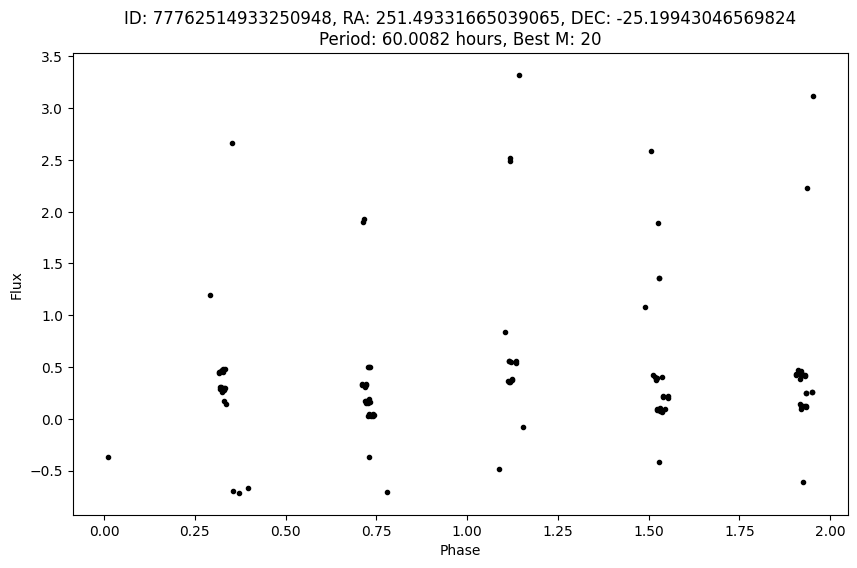

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 303 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 303 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 303 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 303 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


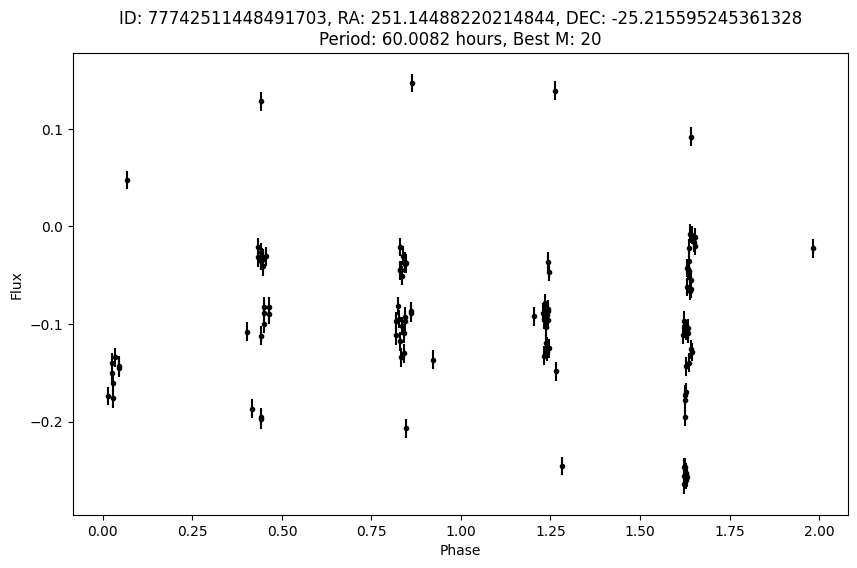

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 448 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 448 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 448 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 448 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


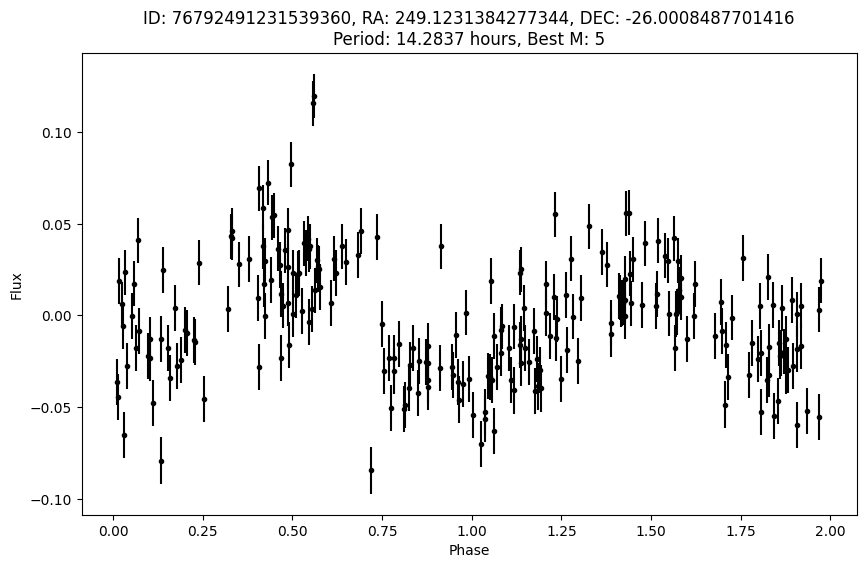

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 443 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 443 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 443 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 443 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


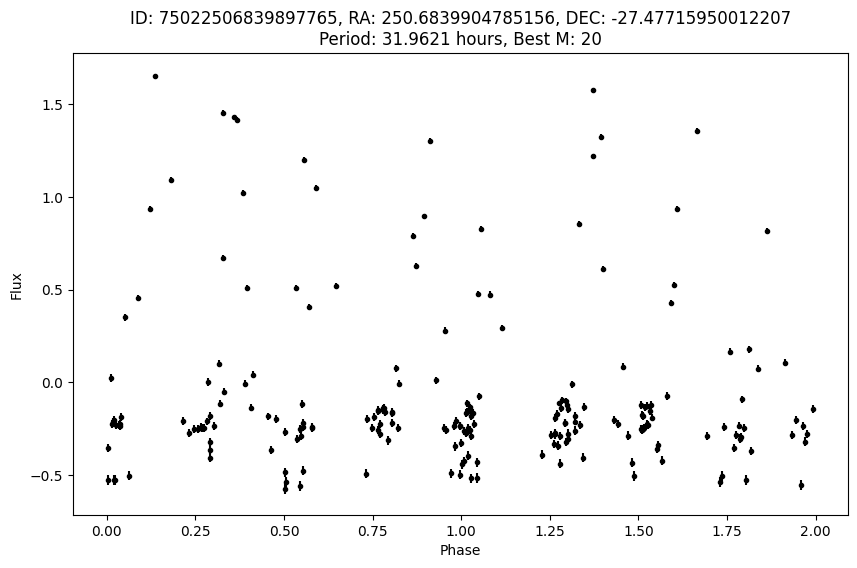

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 111 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 111 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 111 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 111 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


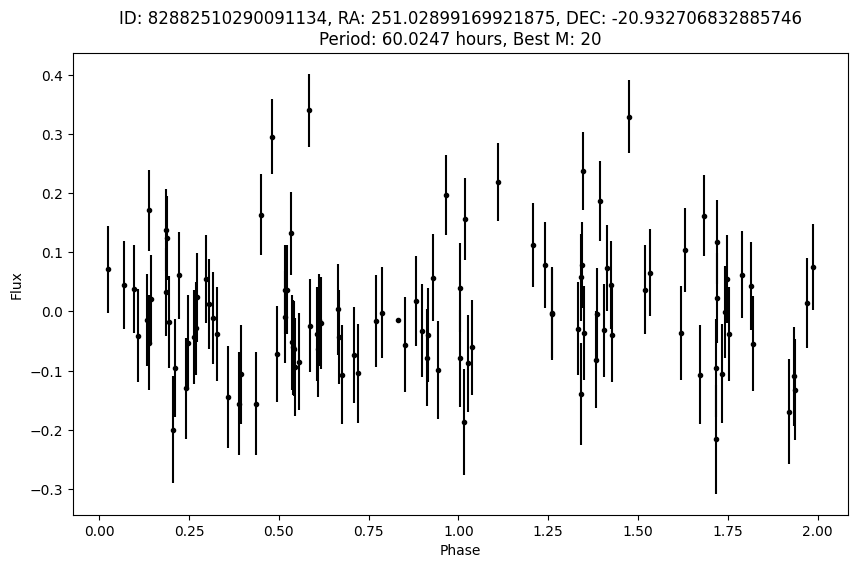

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 365 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 365 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 365 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 365 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


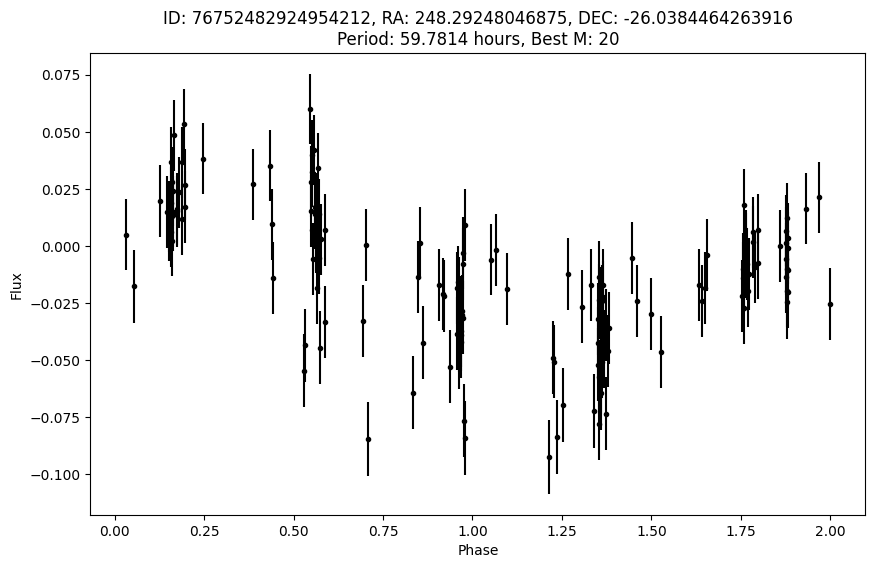

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 414 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 414 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 414 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 414 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


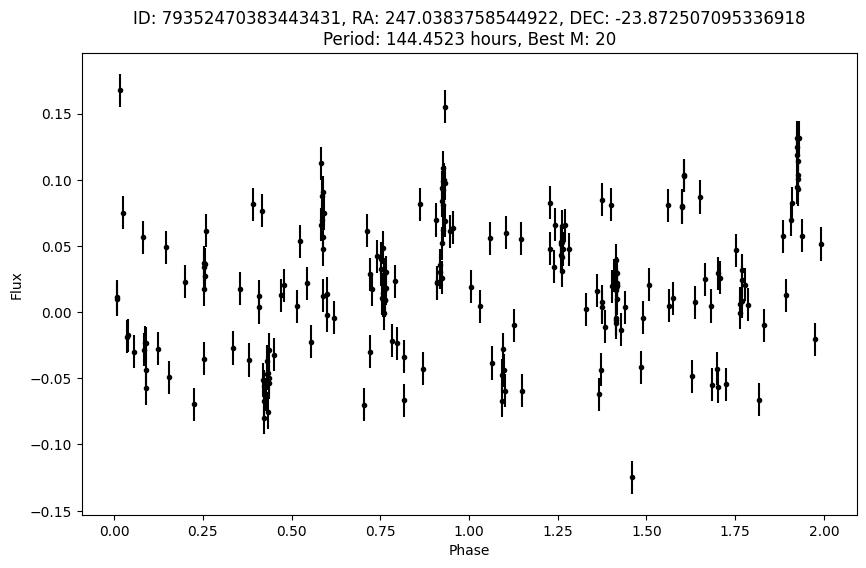

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 441 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 441 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 441 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 441 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


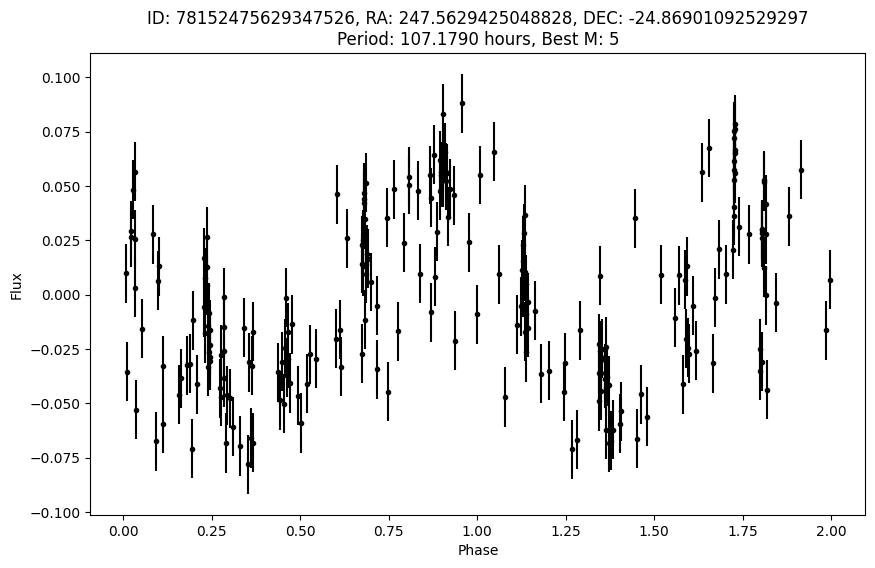

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 114 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 114 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 114 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 114 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


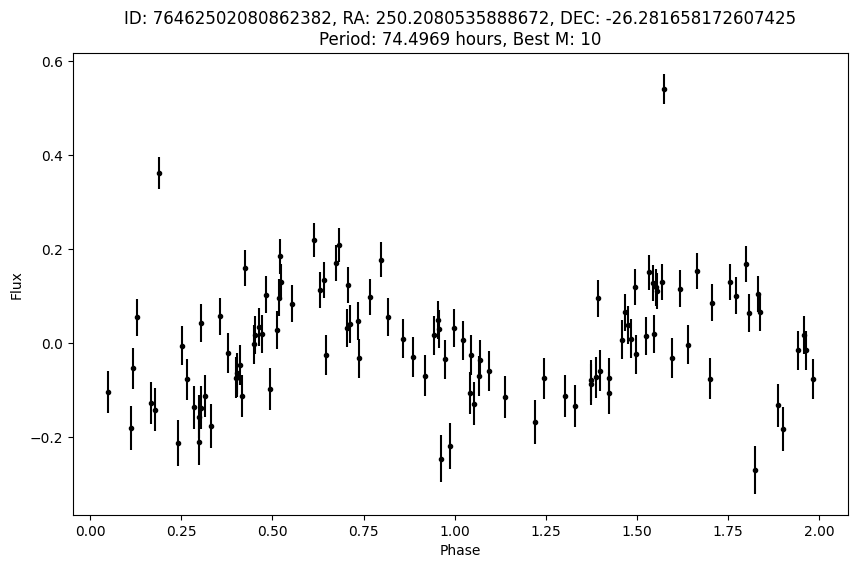

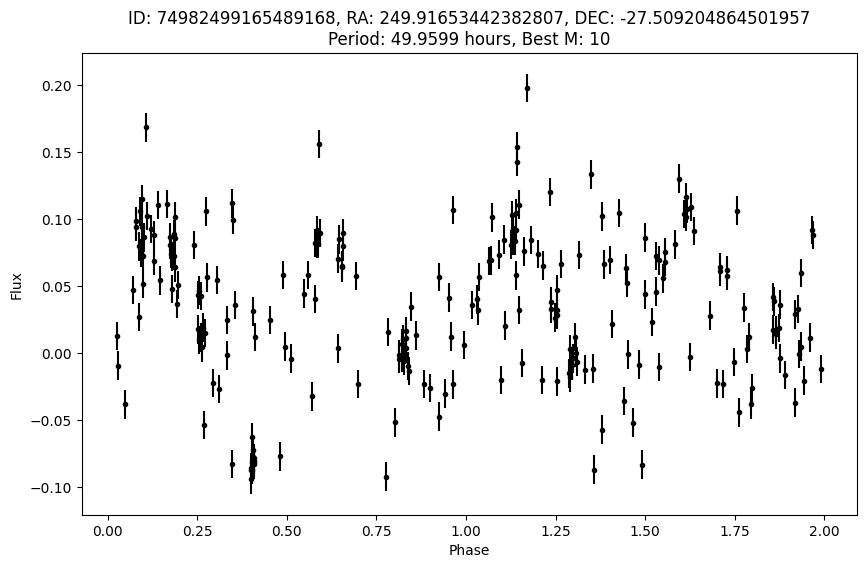

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 118 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 118 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 118 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 118 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


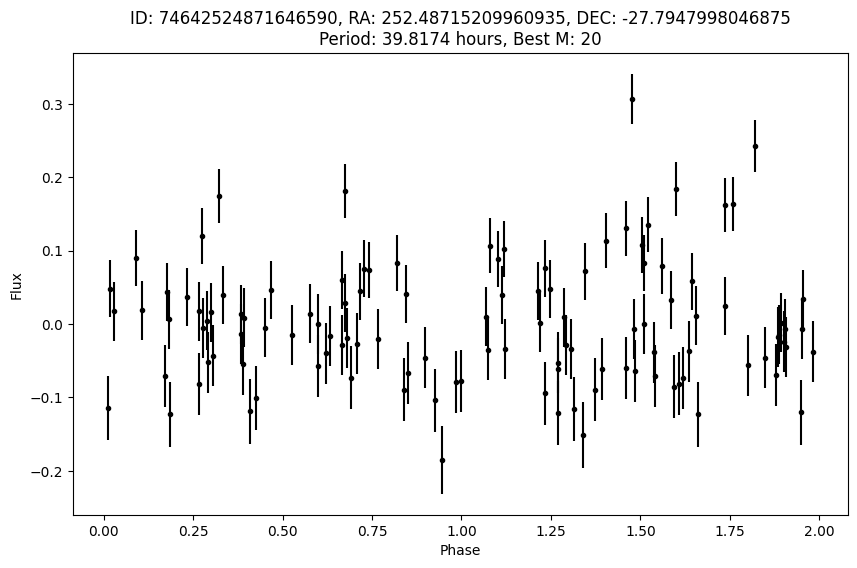

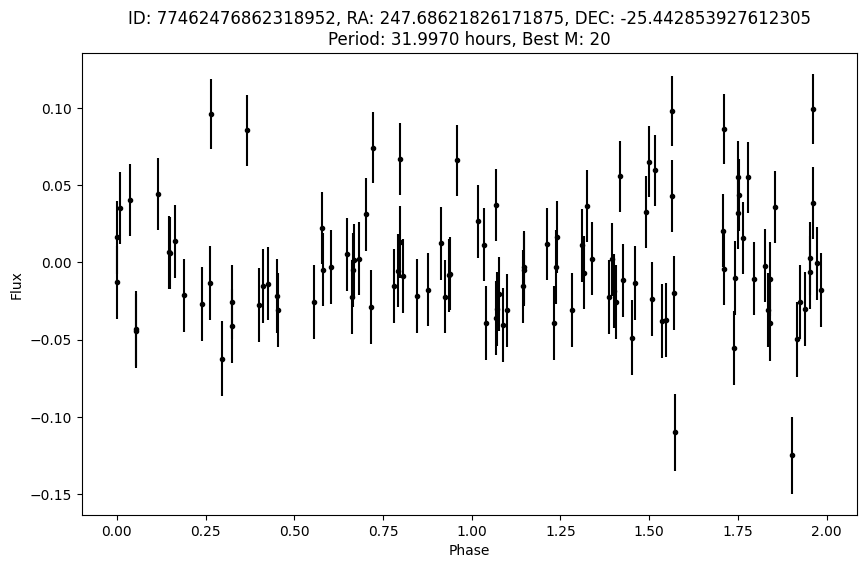

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 335 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 335 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 335 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 335 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


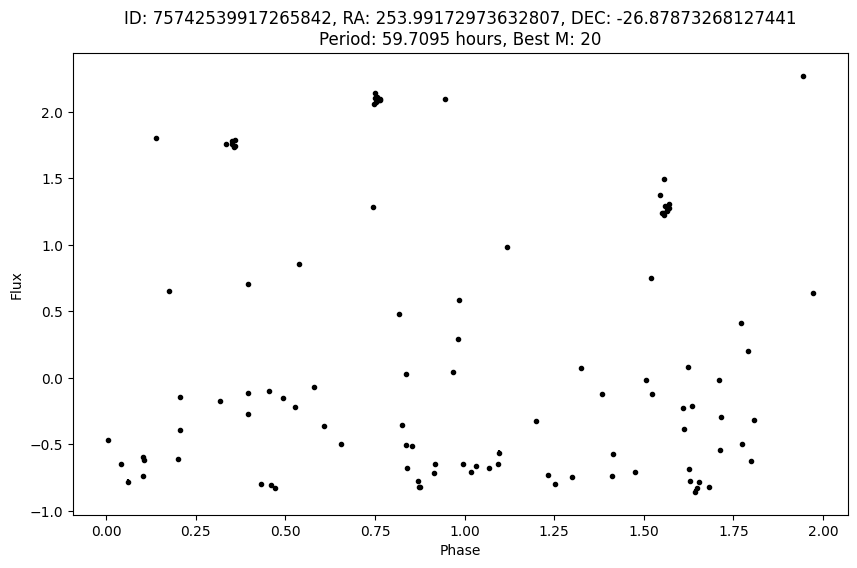

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 123 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 123 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 123 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 123 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


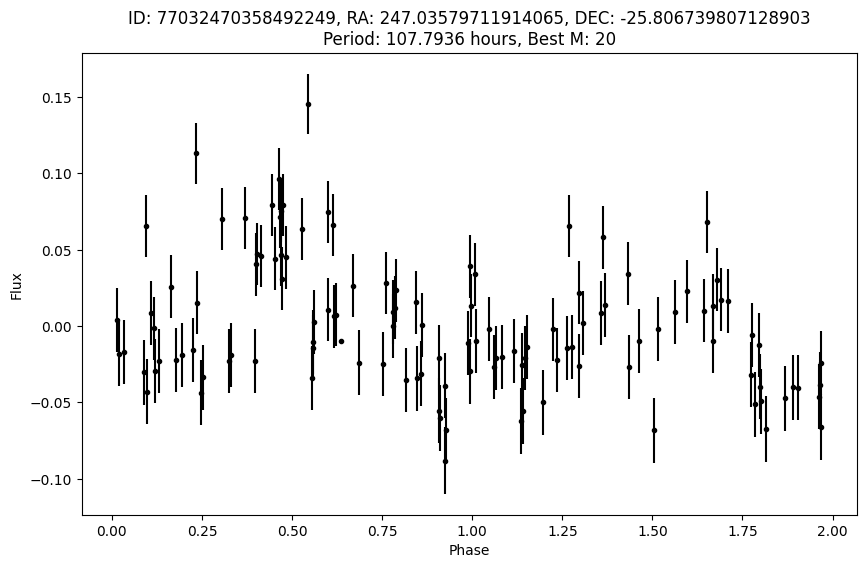

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 119 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 119 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 119 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 119 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


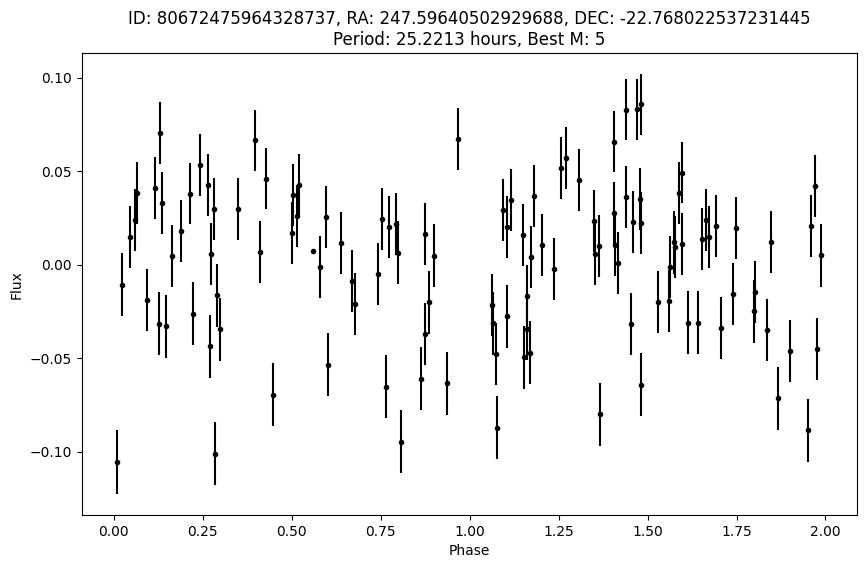

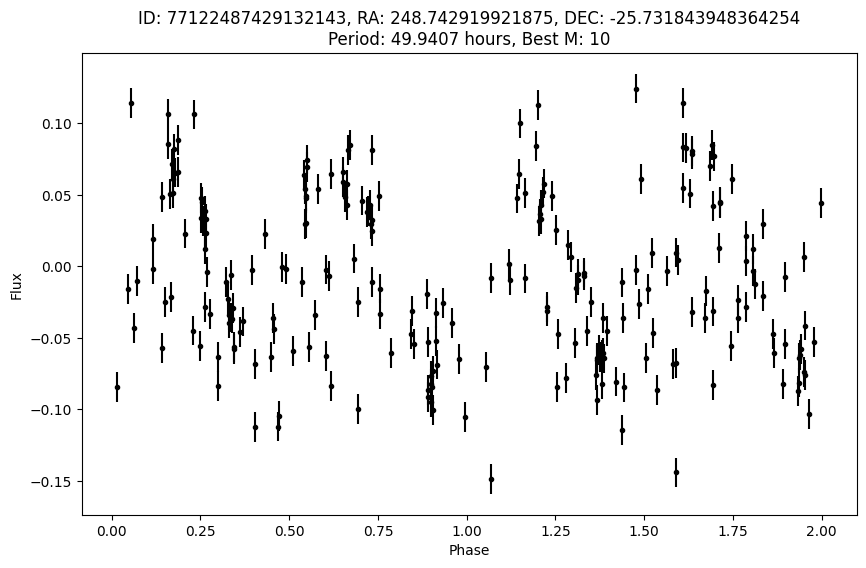

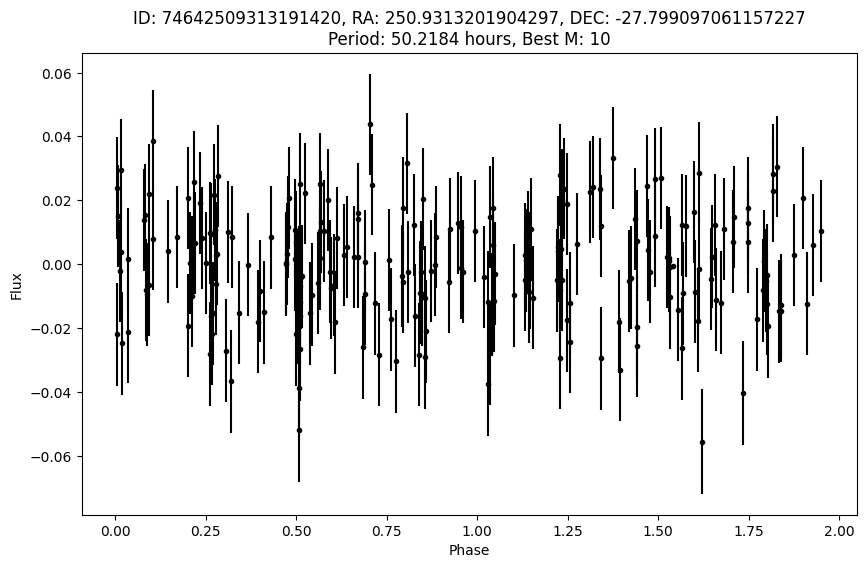

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 72 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 72 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 72 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 72 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


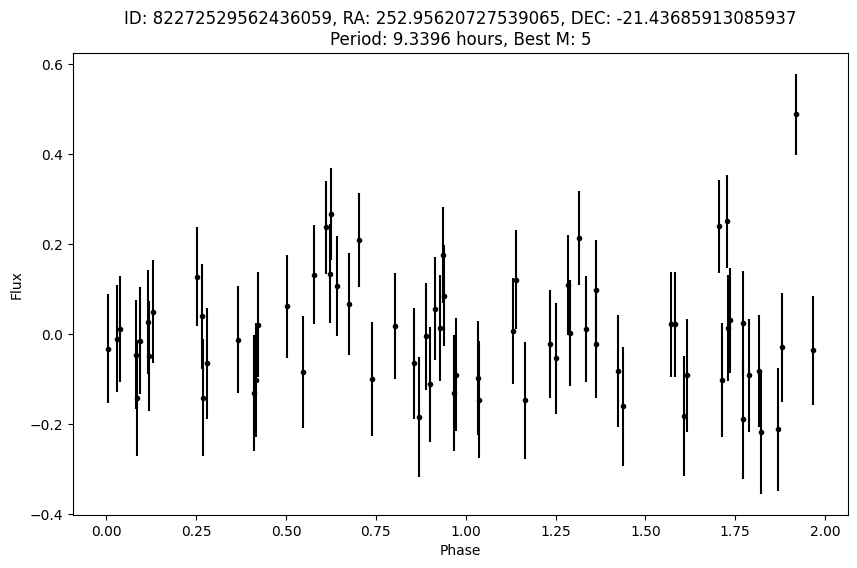

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 350 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 350 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 350 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 350 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


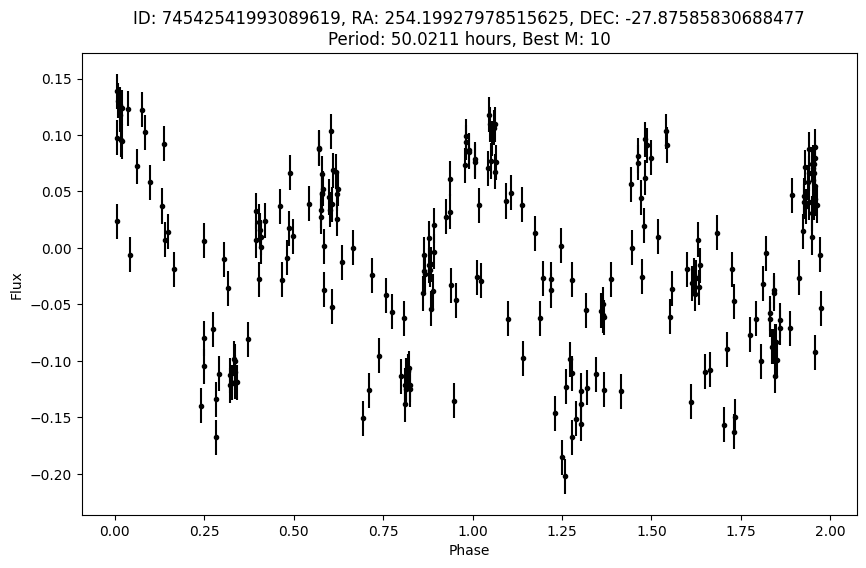

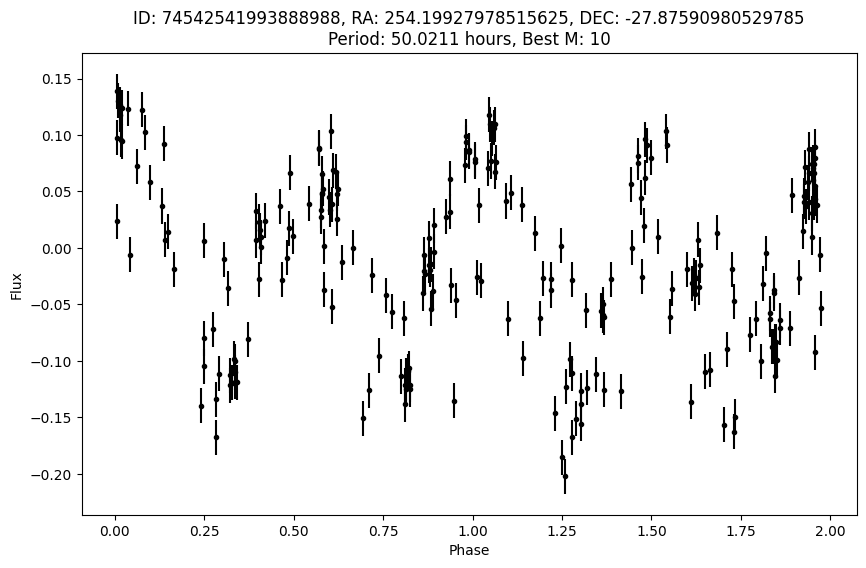

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 125 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 125 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 125 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 125 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


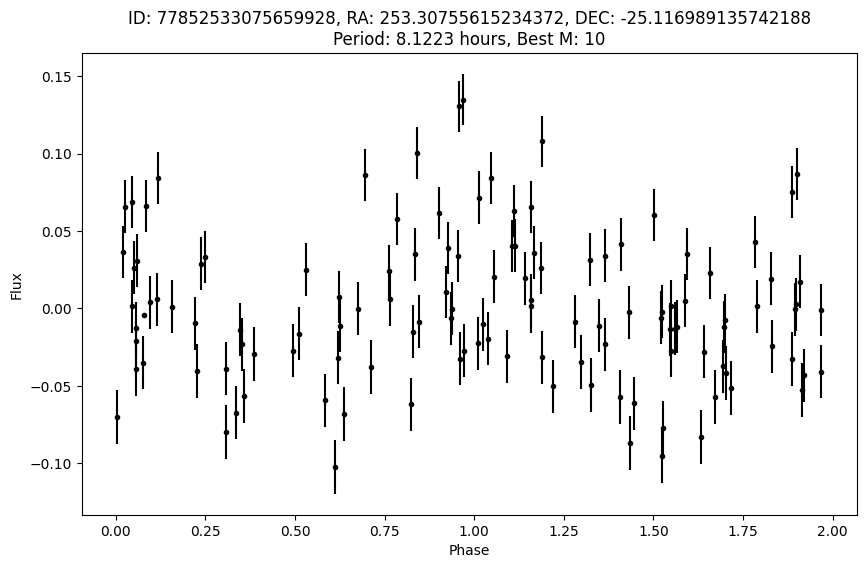

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 445 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 445 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 445 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 445 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


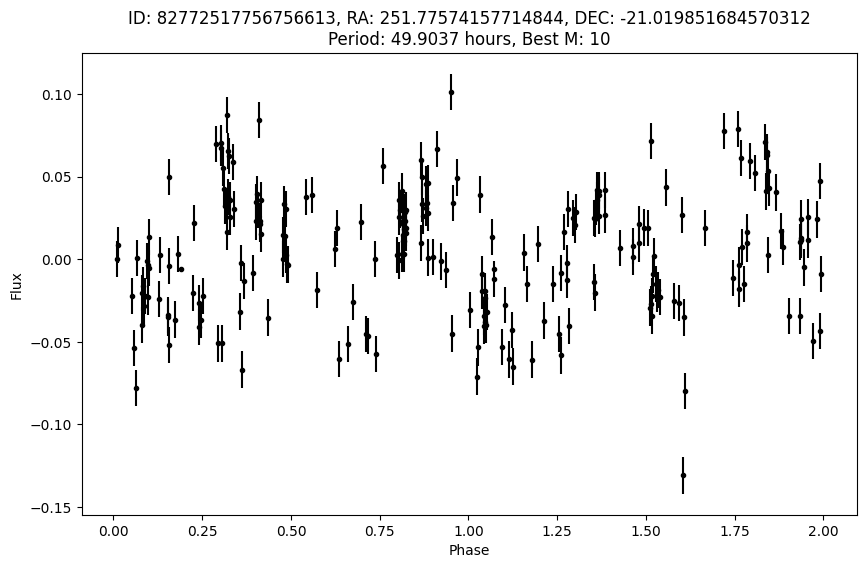

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 122 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 122 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 122 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 122 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


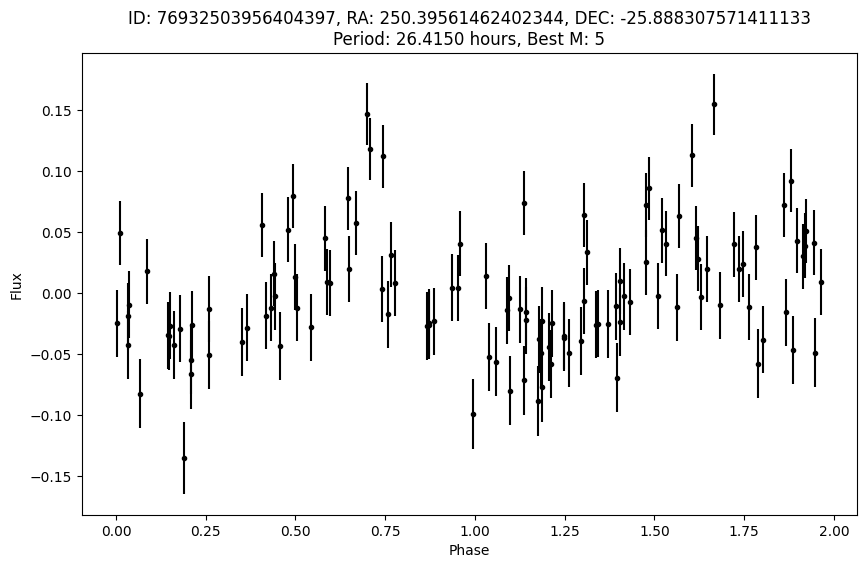

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 354 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 354 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 354 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 354 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


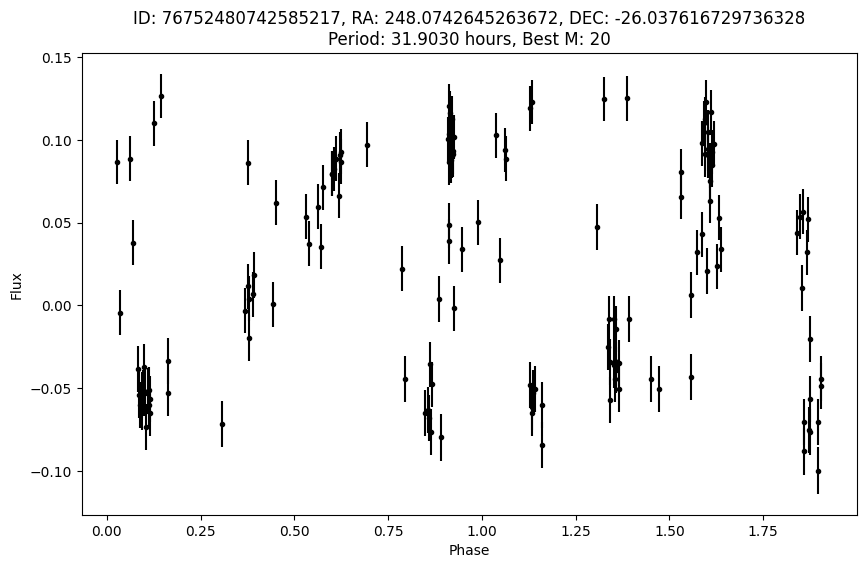

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 109 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 109 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 109 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 109 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


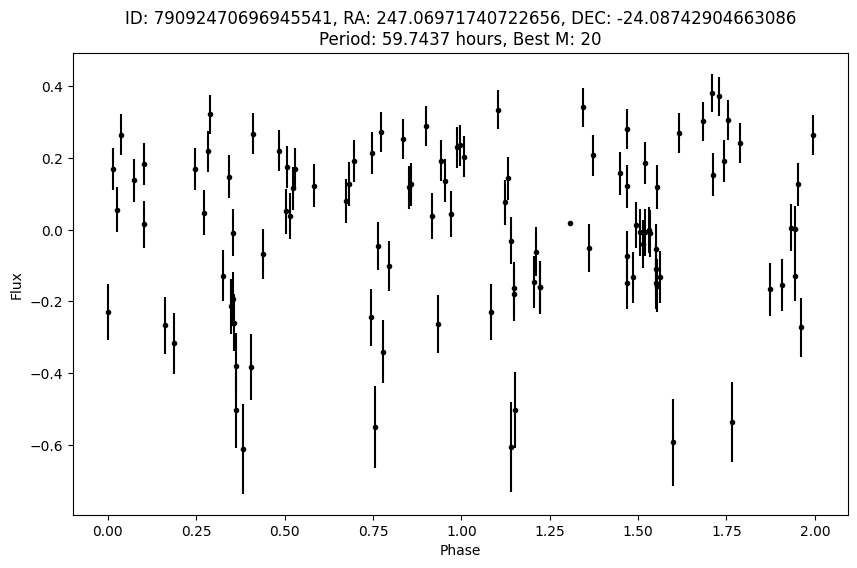

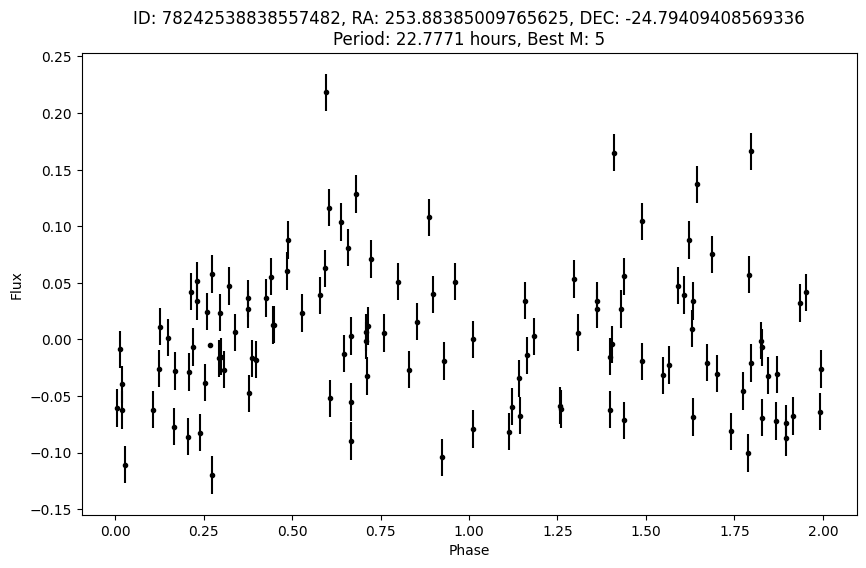

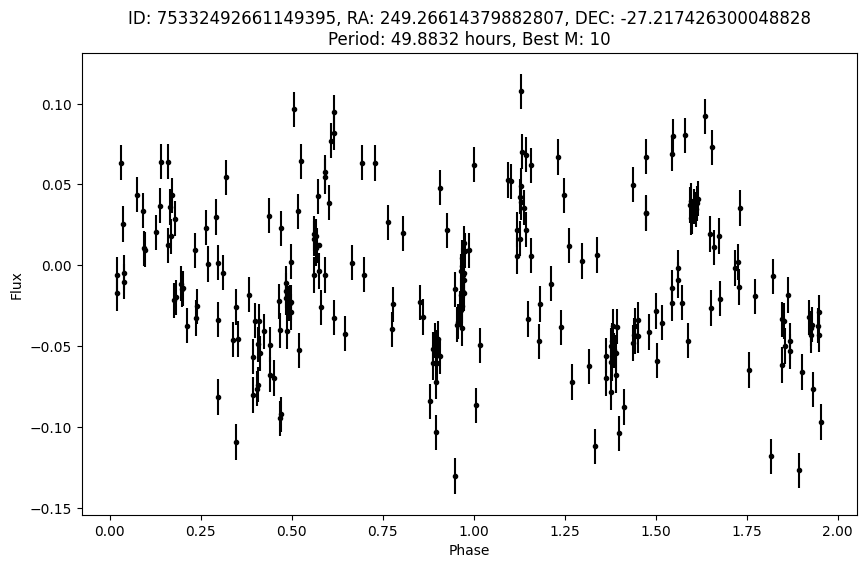

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 428 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 428 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 428 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 428 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


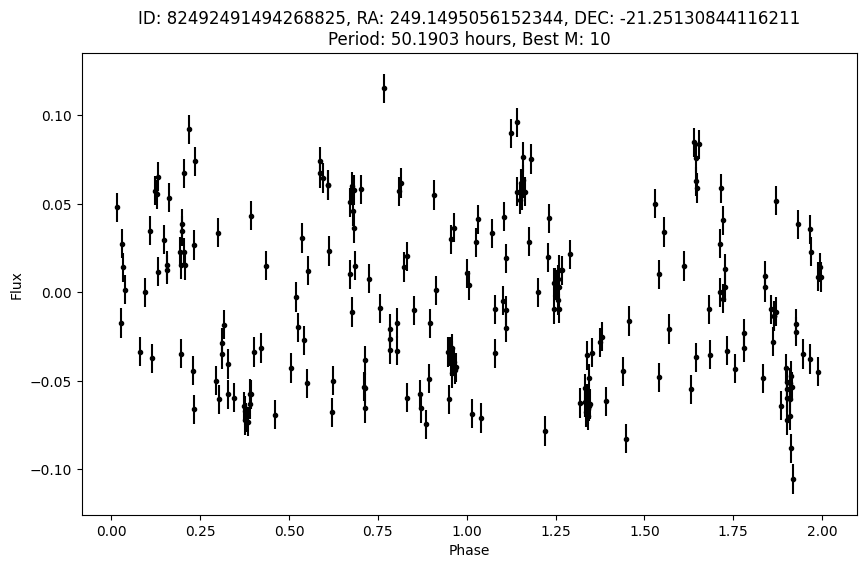

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 446 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 446 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 446 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 446 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


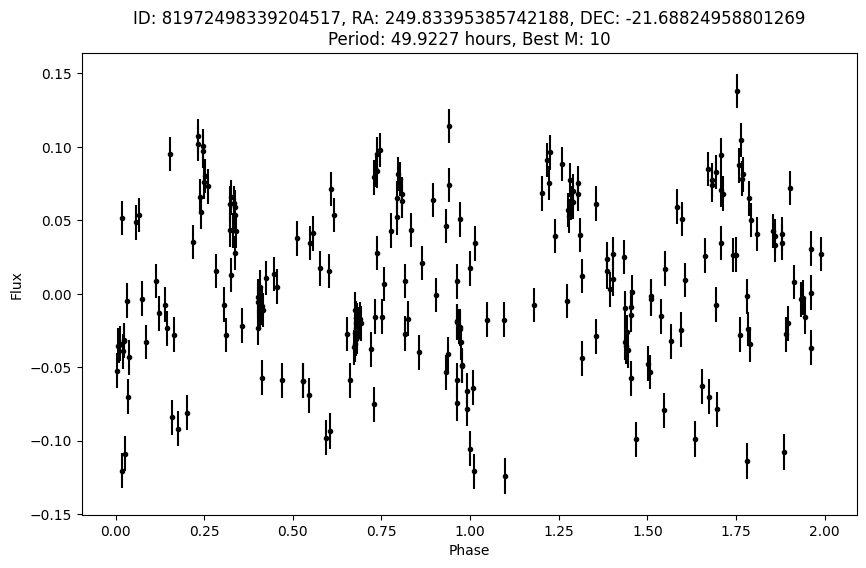

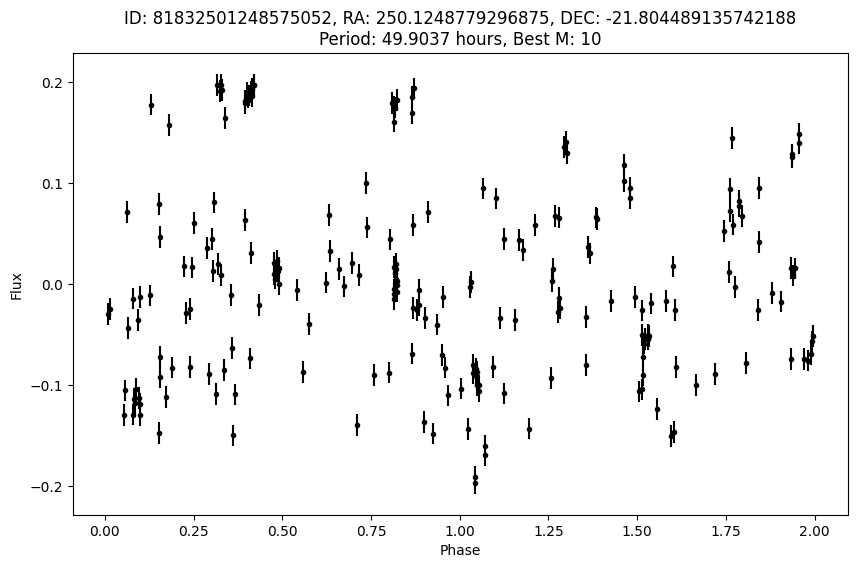

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 60 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 60 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 60 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 60 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


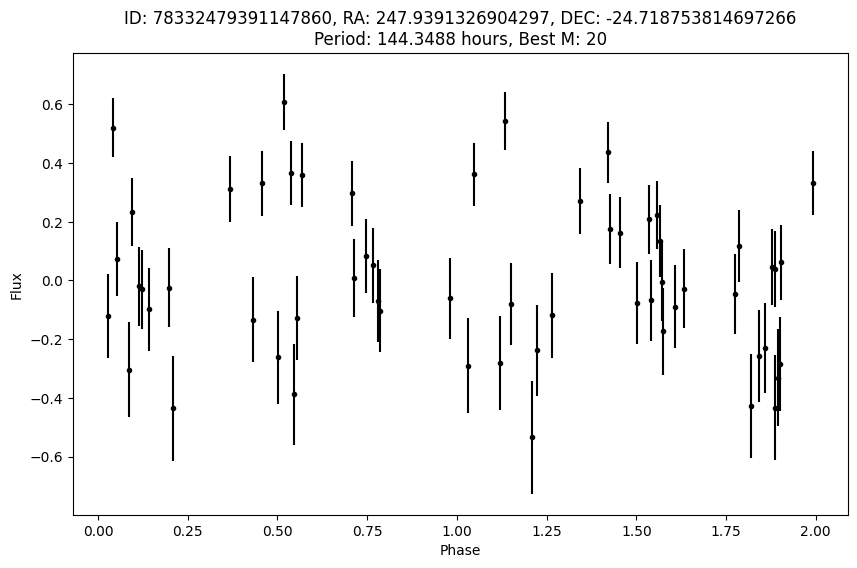

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 187 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 187 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 187 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 187 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


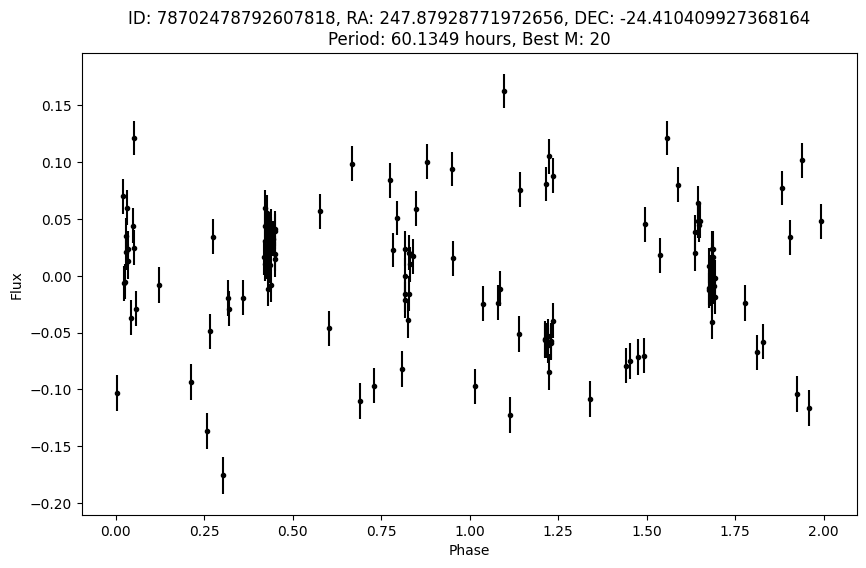

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 439 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 439 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 439 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 439 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


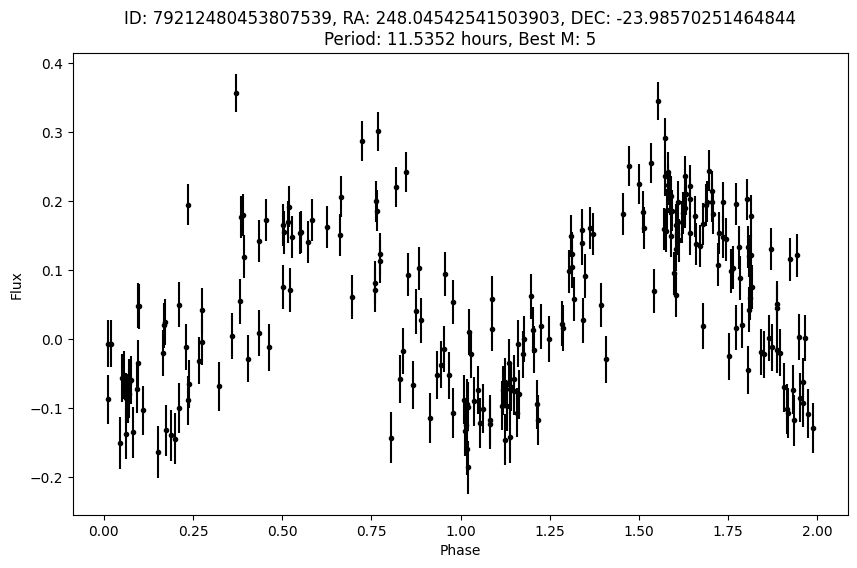

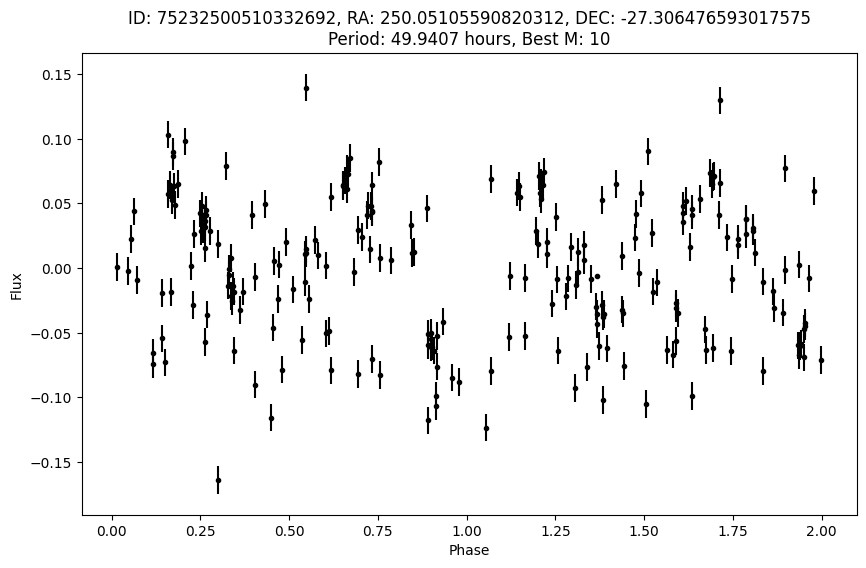

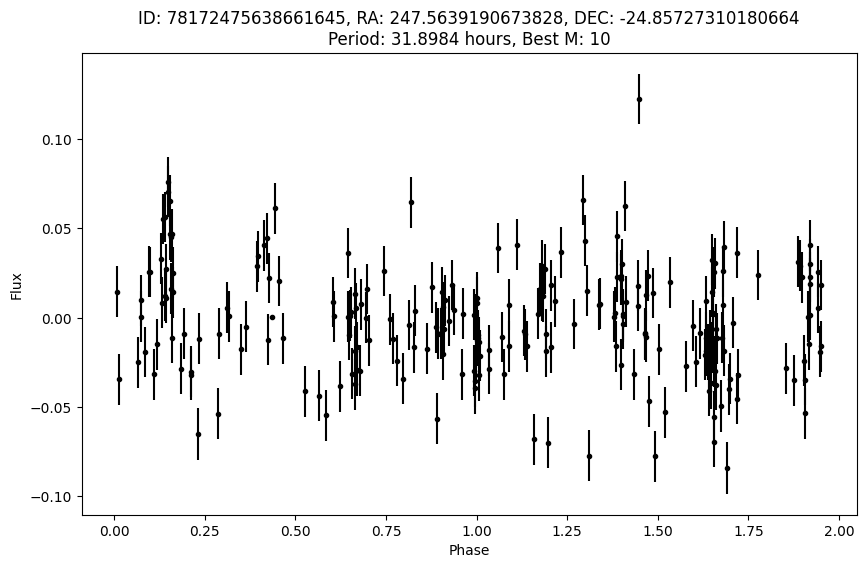

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 69 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 69 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 69 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 69 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


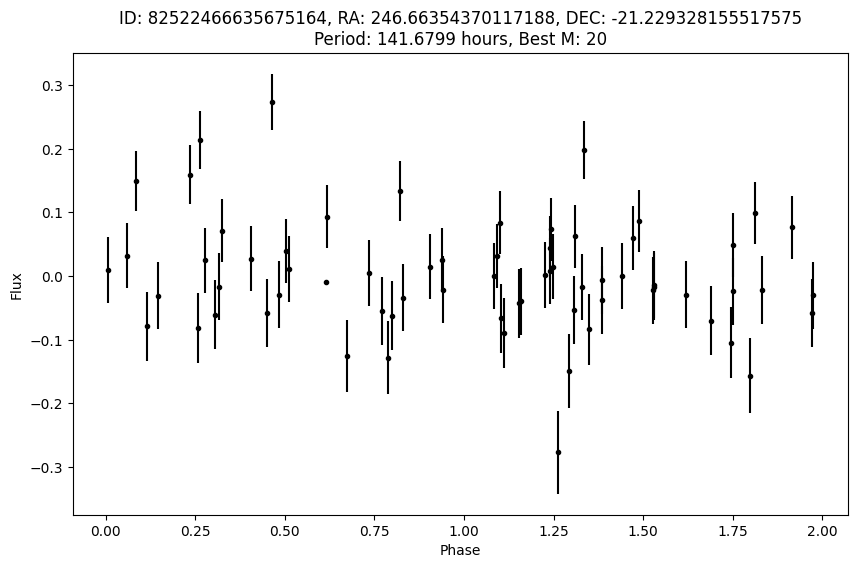

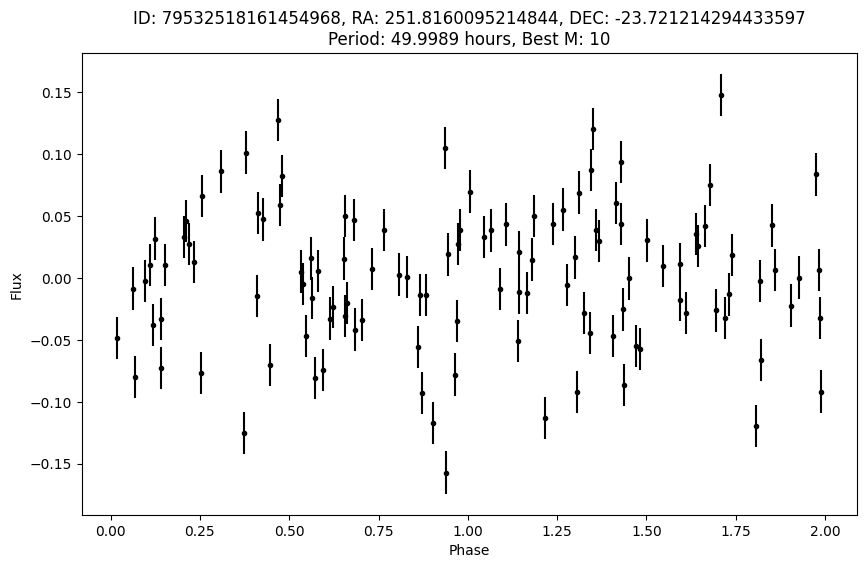

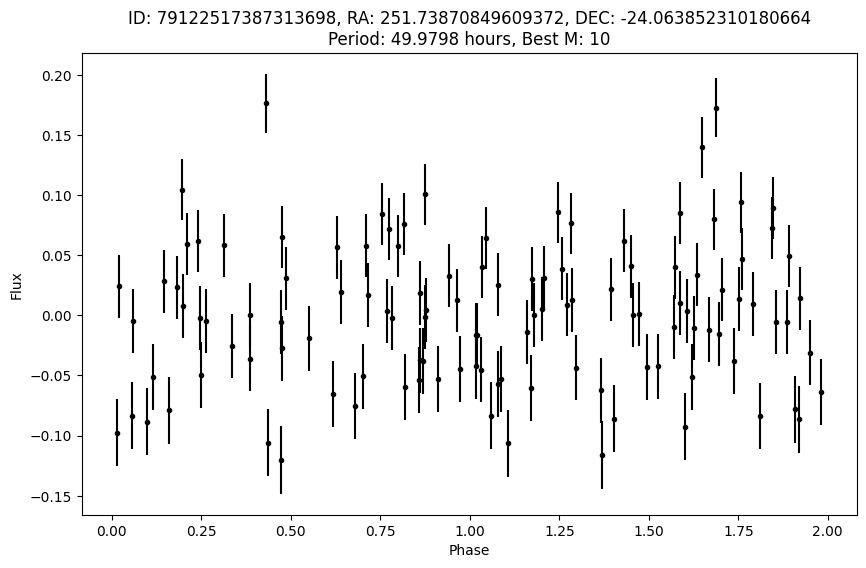

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 105 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 105 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 105 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 105 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


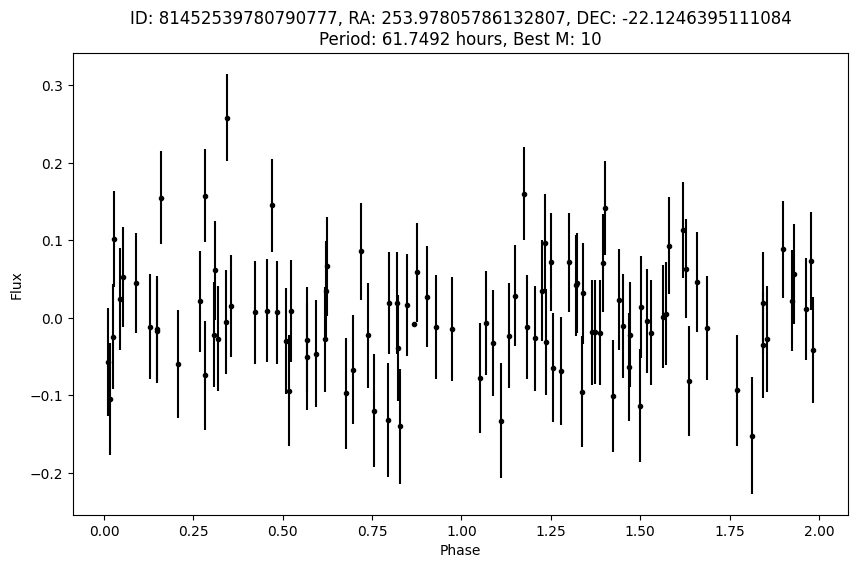

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 444 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 444 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 444 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 444 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


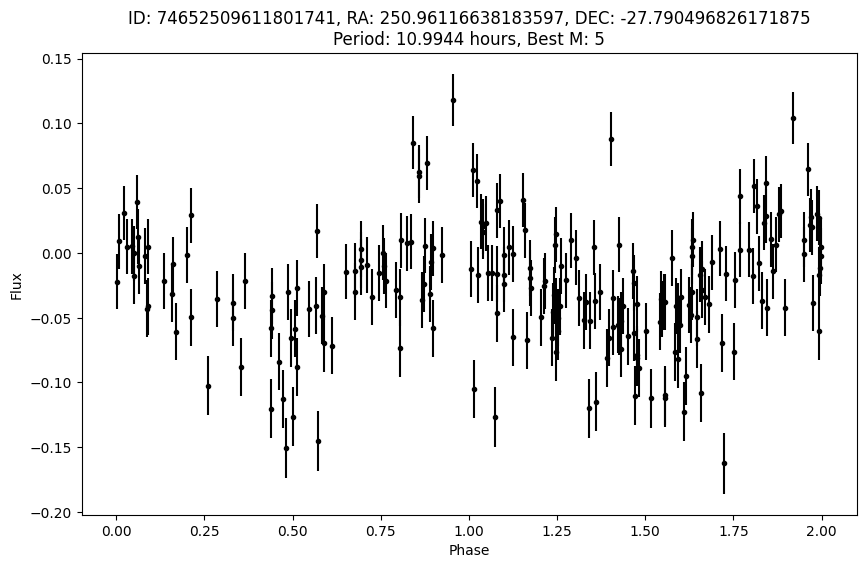

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 115 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 115 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 115 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 115 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


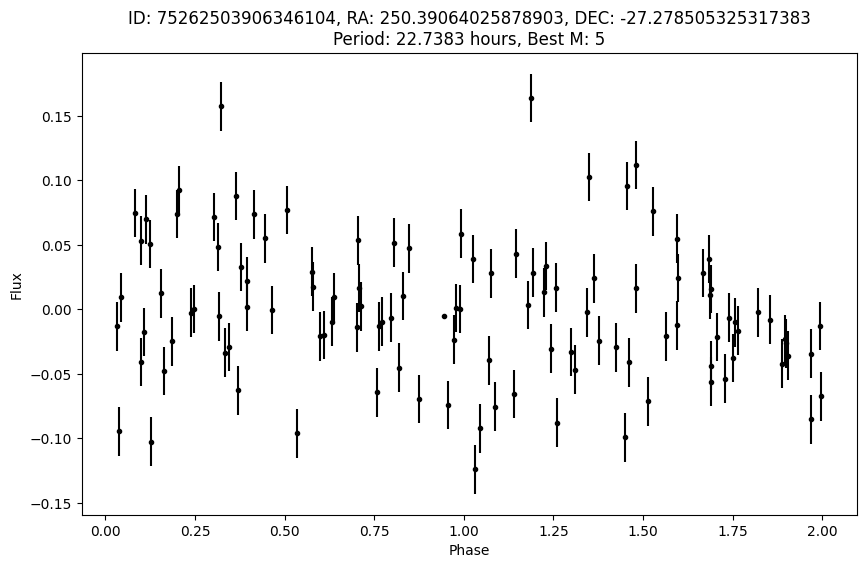

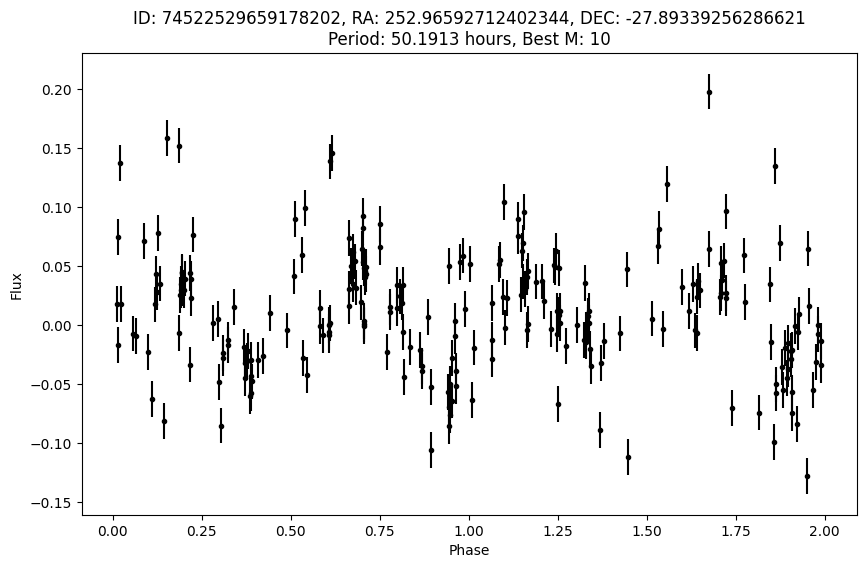

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 496 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 496 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 496 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 496 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


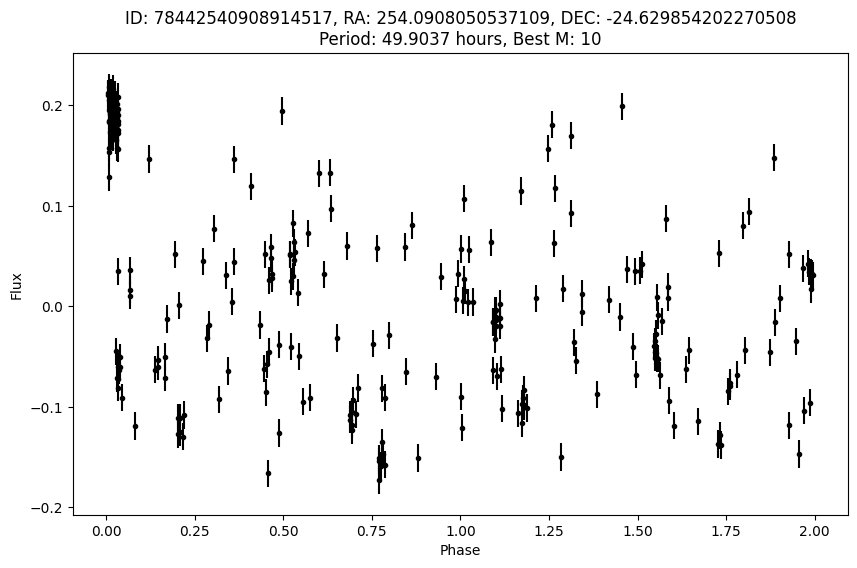

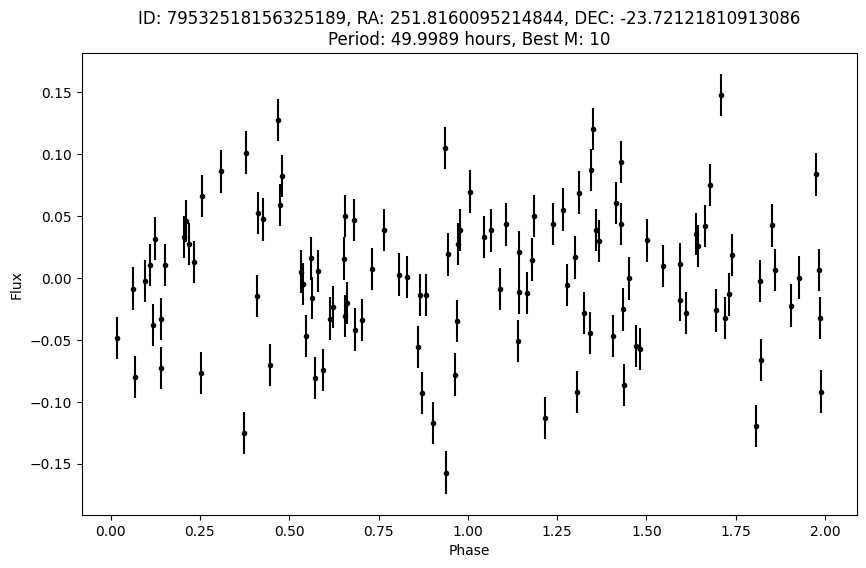

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 99 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 99 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 99 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 99 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


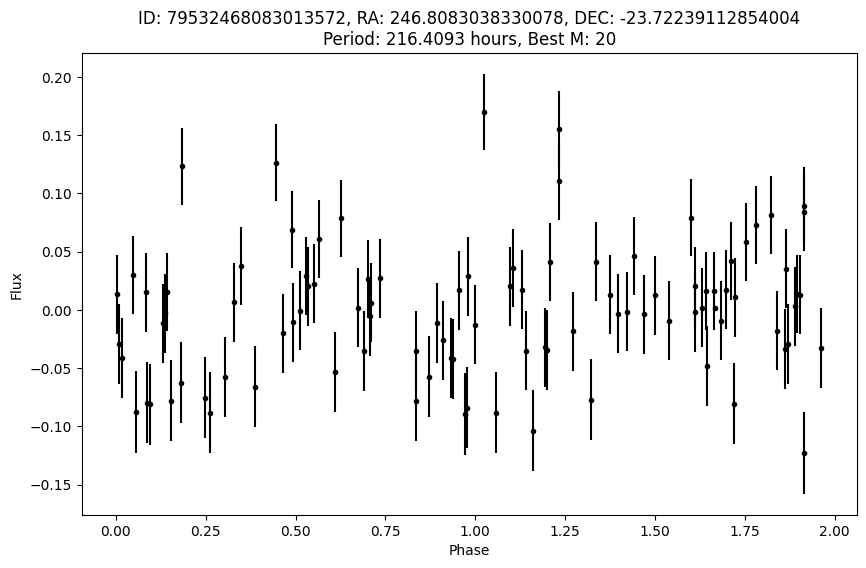

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 71 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 71 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 71 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 71 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


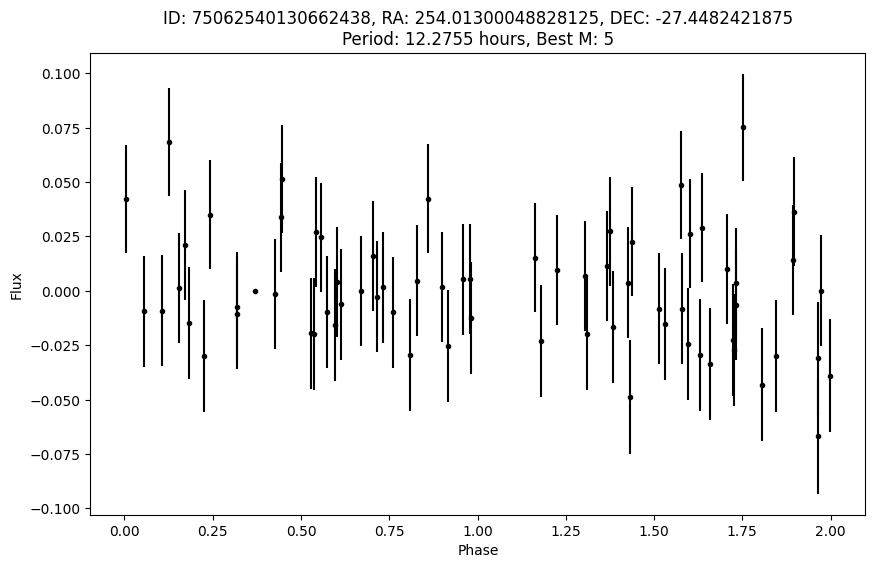

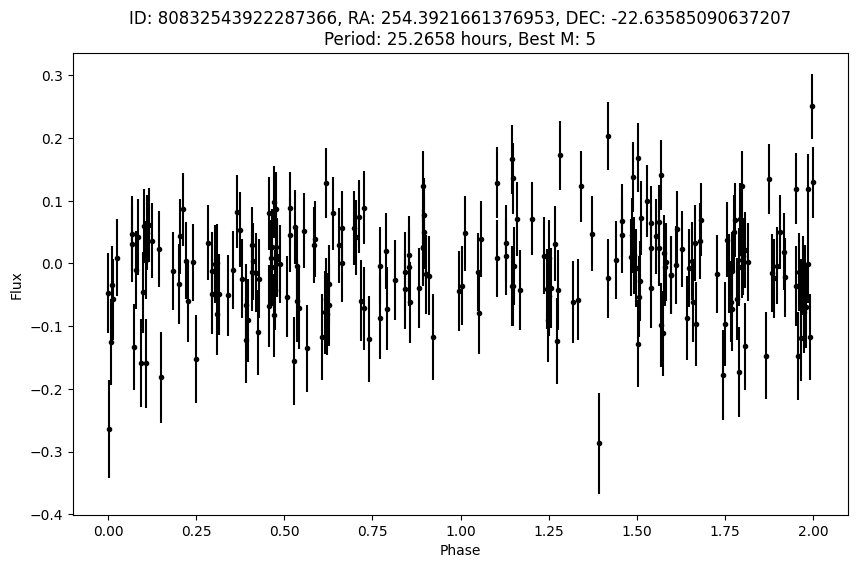

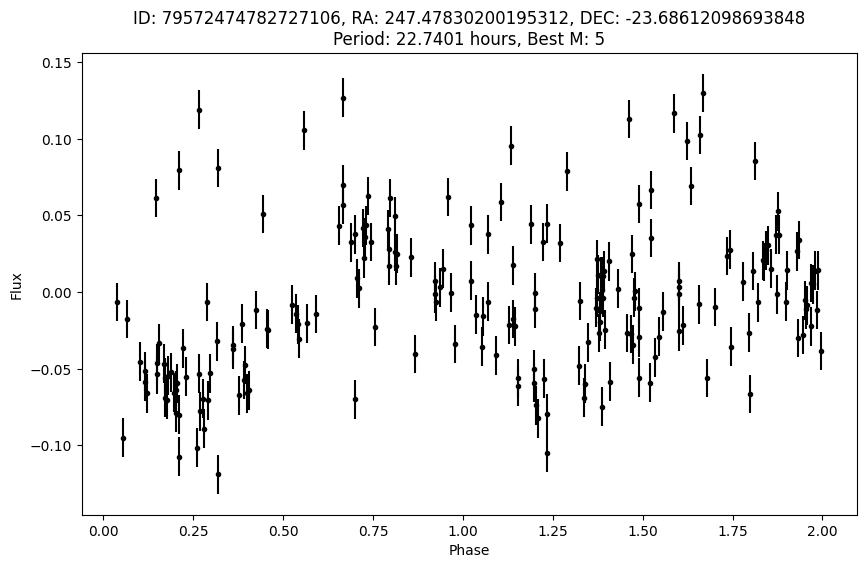

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 424 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 424 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 424 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 424 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


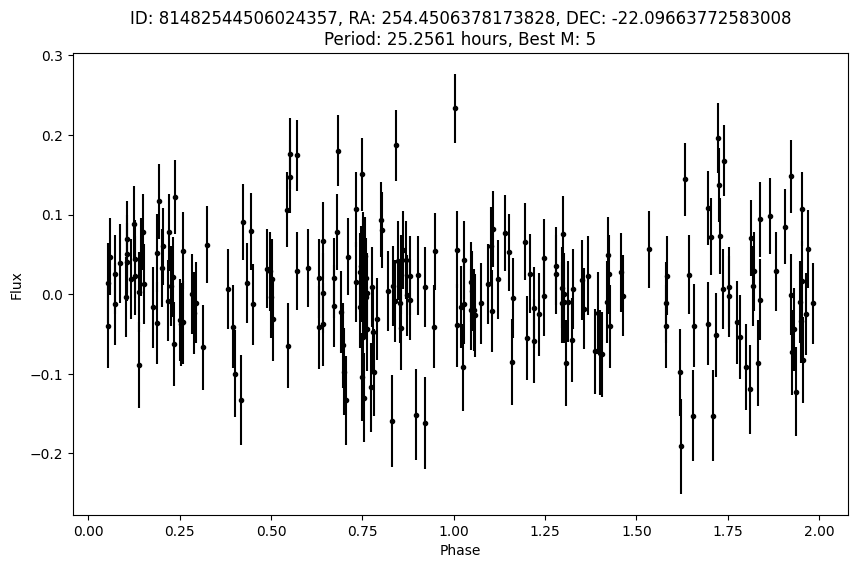

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 121 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 121 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 121 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 121 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


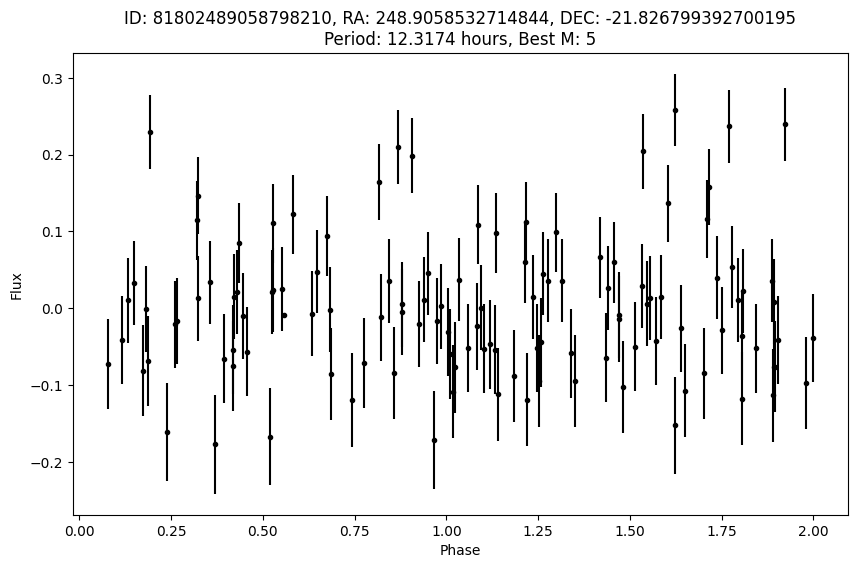

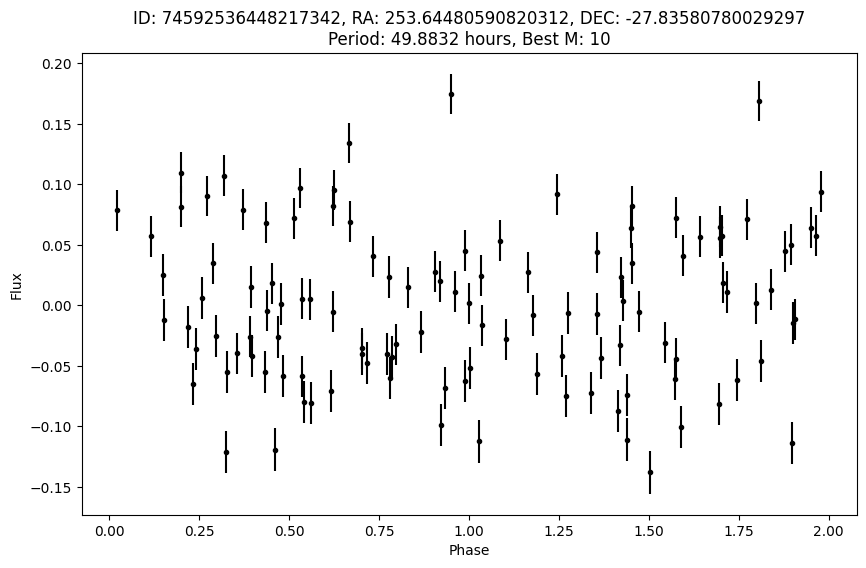

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 466 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 466 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 466 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 466 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


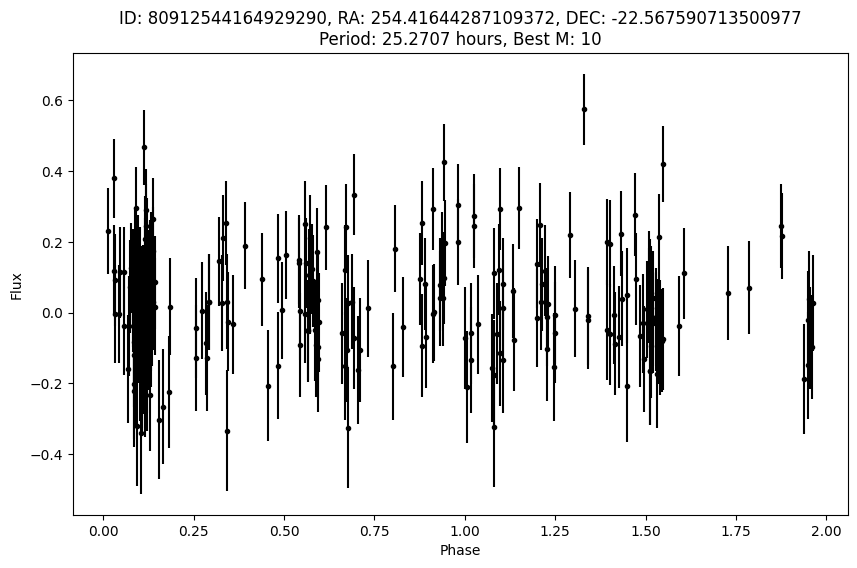

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 336 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 336 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 336 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 336 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


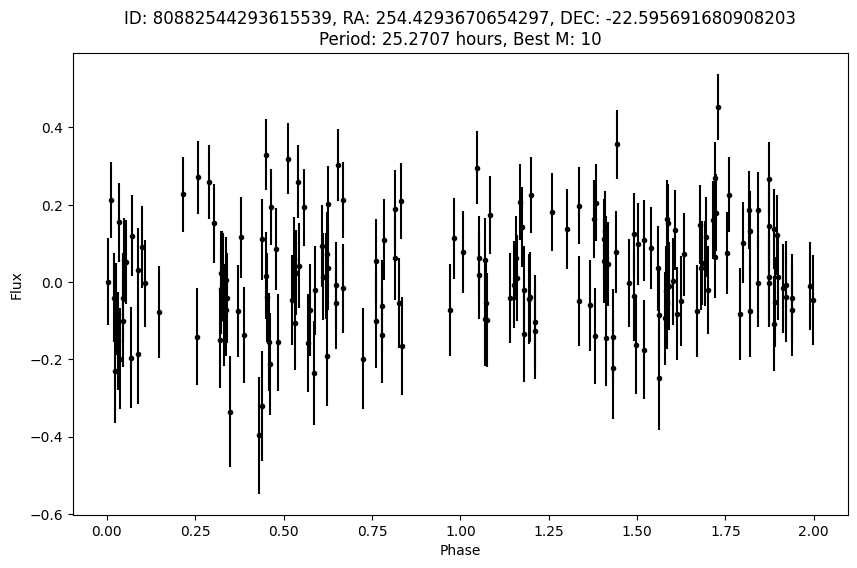

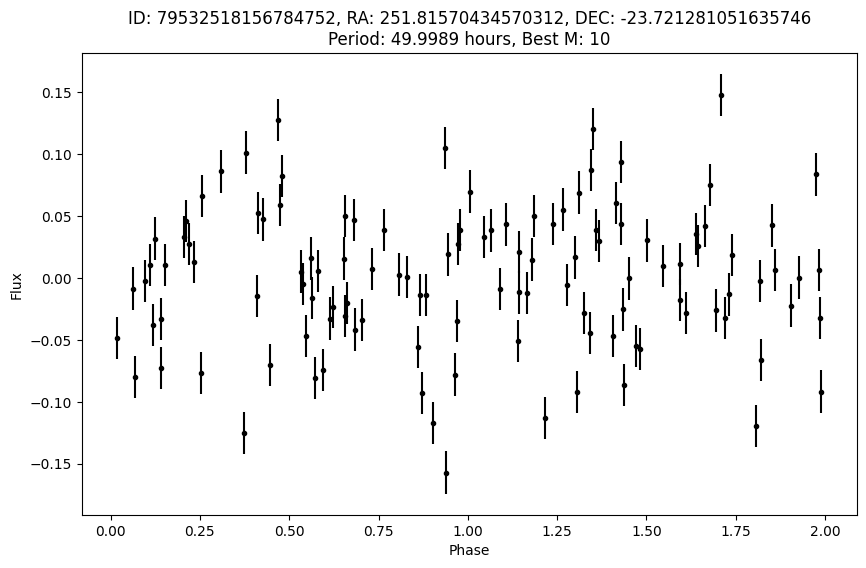

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 442 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 442 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 442 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 442 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


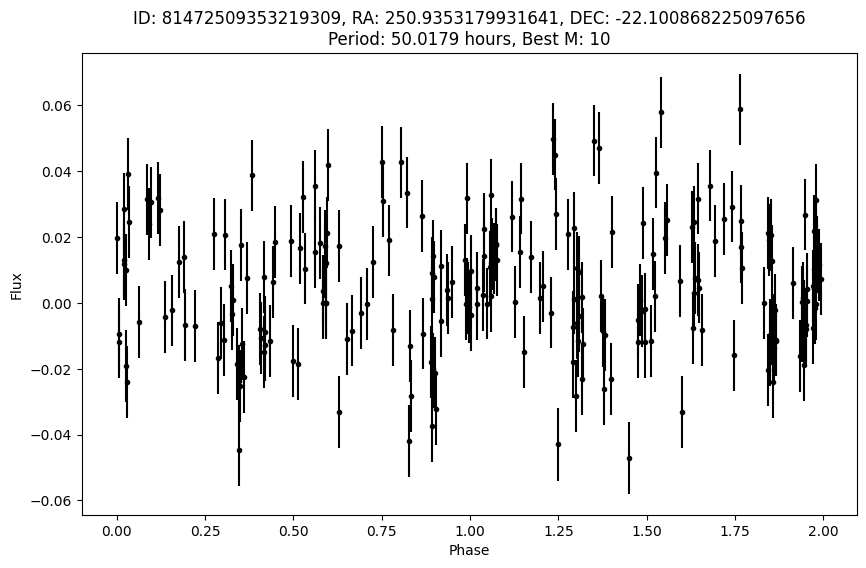

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 396 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 396 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 396 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 396 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


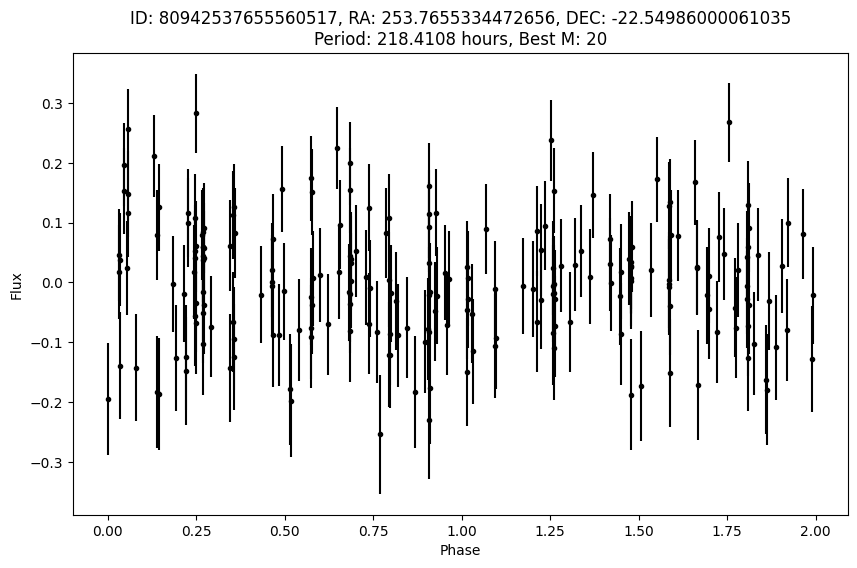

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 298 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 298 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 298 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 298 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


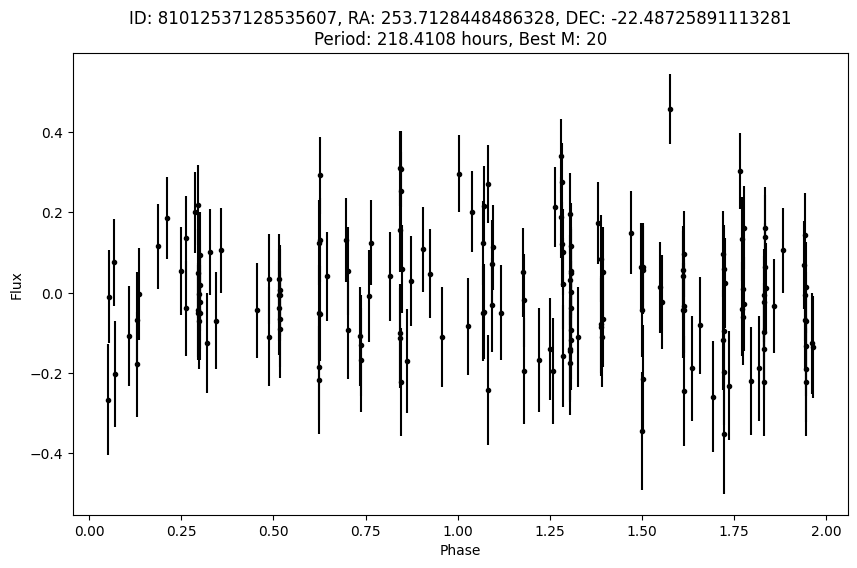

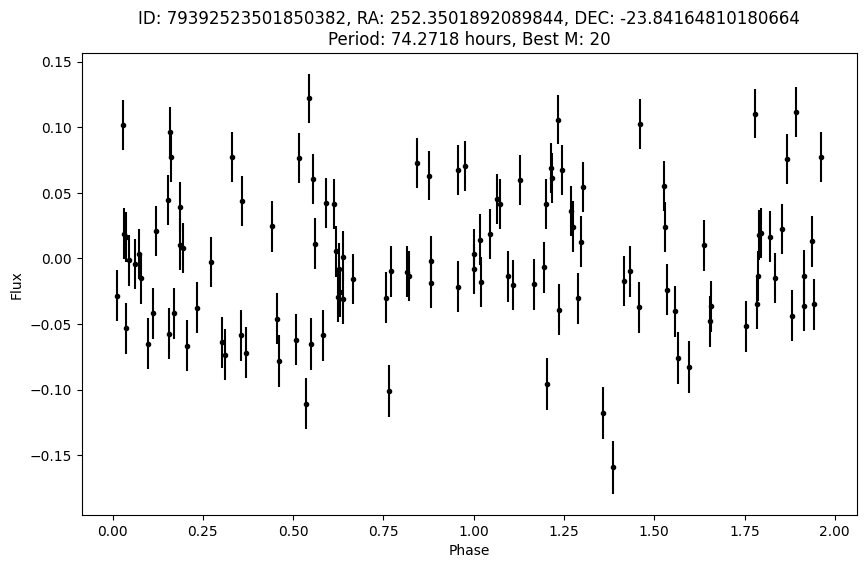

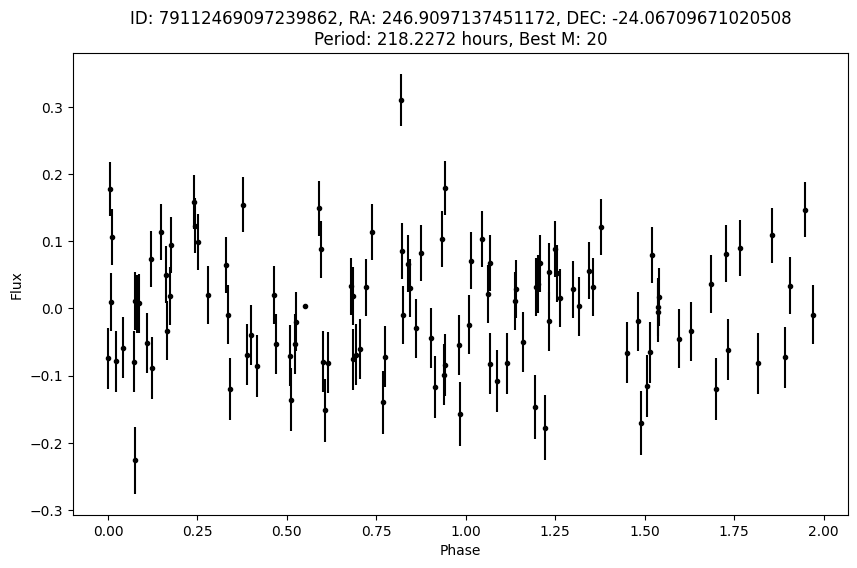

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 281 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 281 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 281 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 281 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


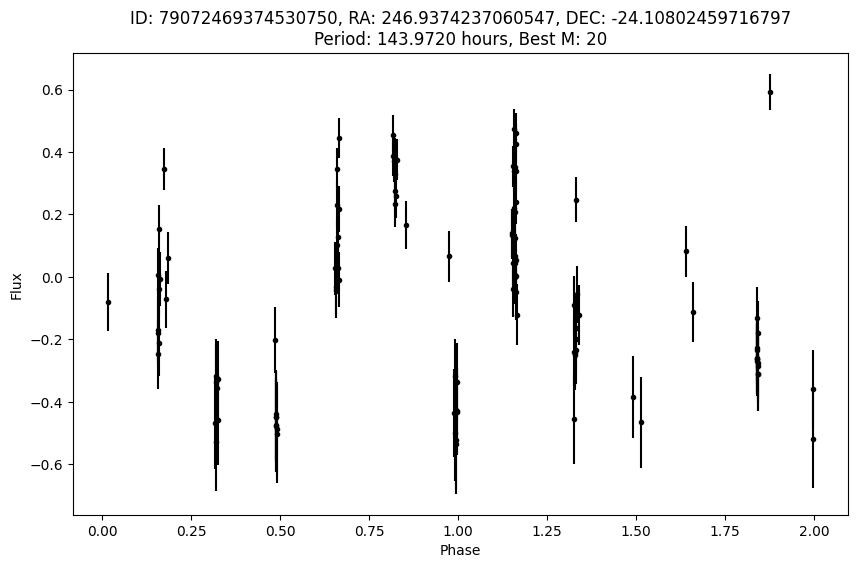

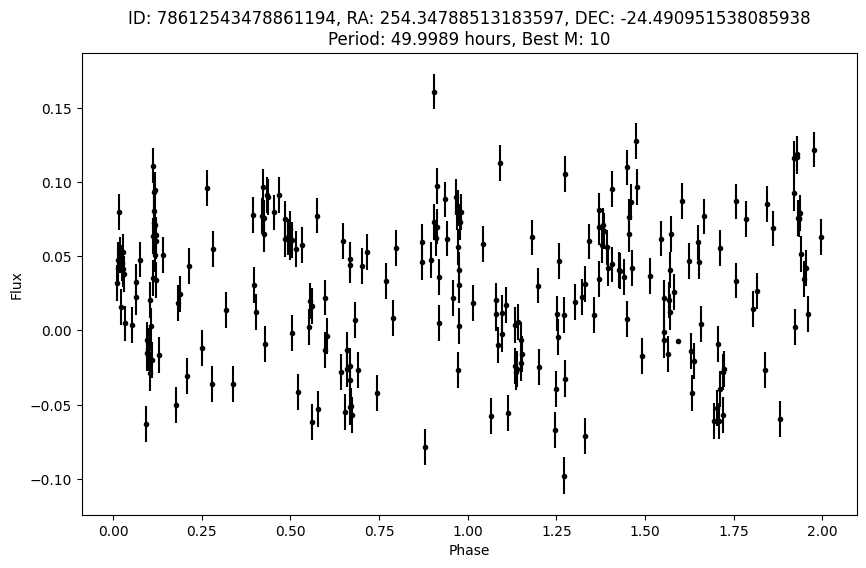

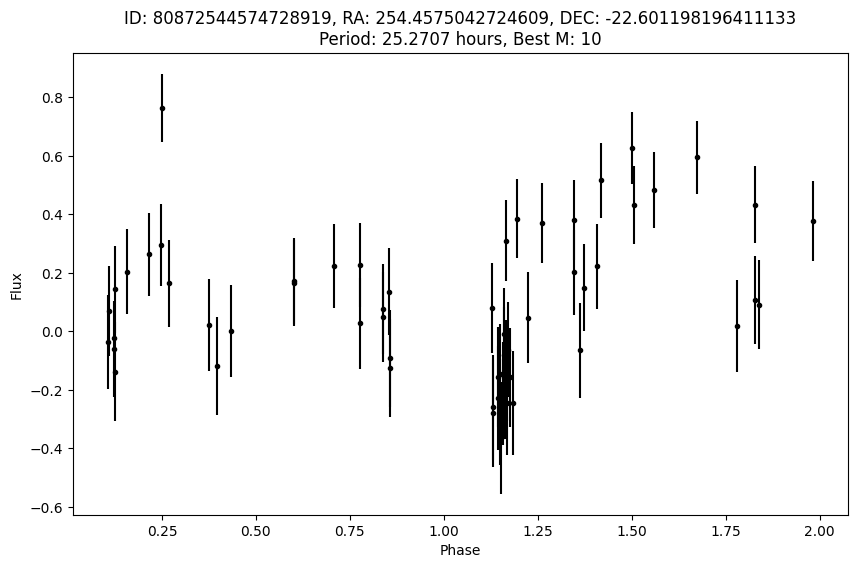

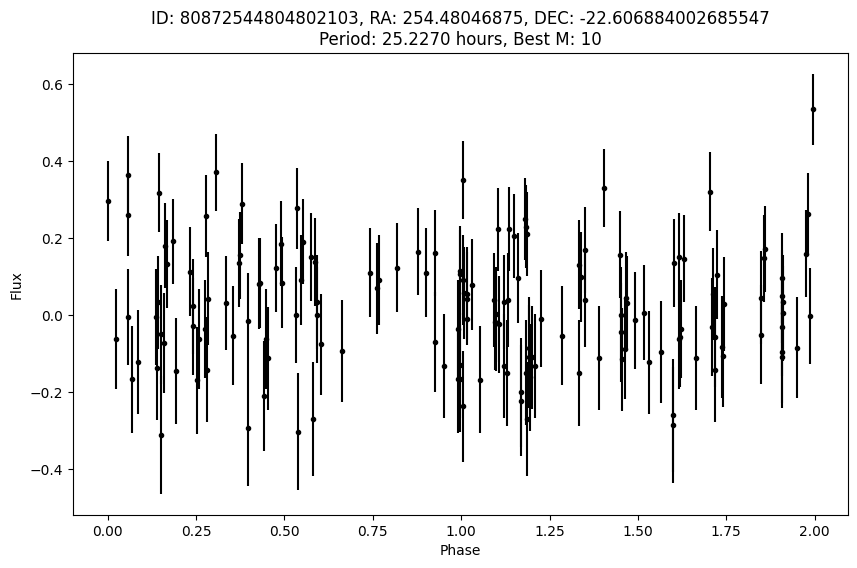

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 418 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 418 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 418 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 418 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


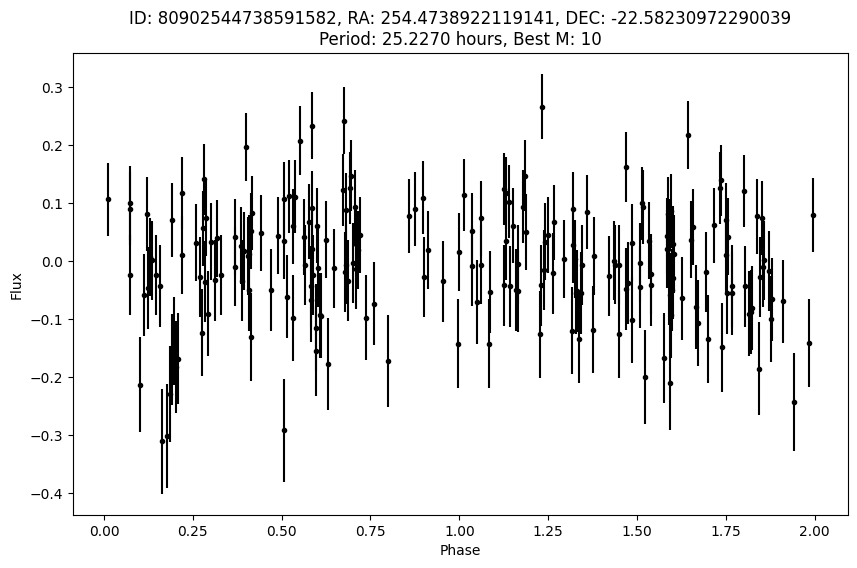

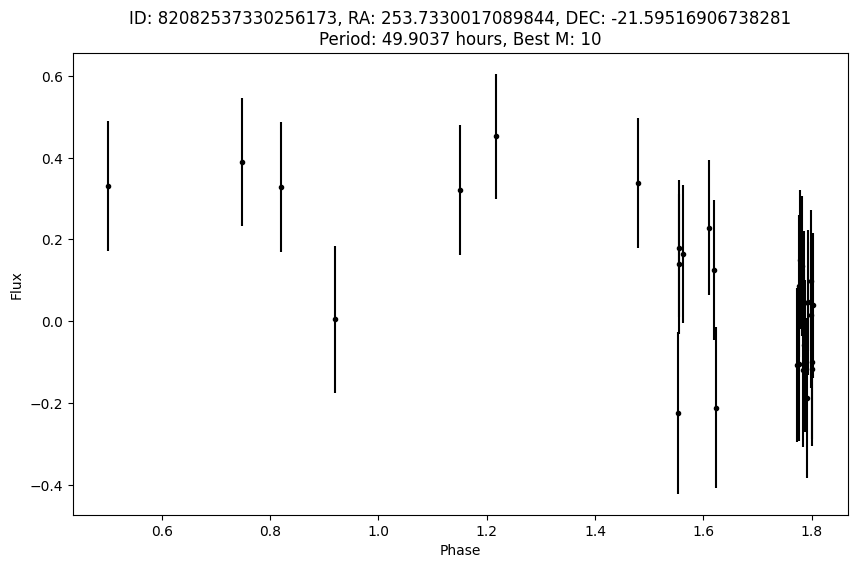

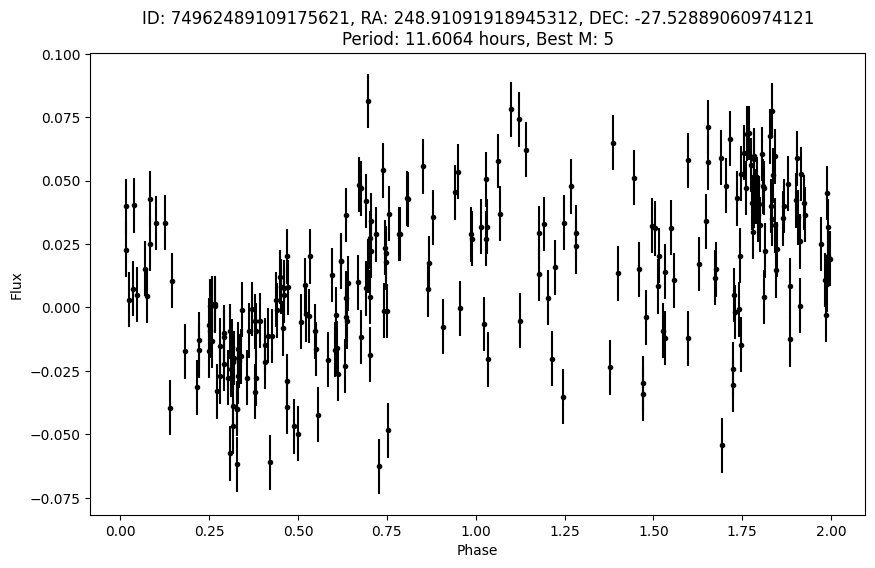

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 126 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 126 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 126 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 126 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


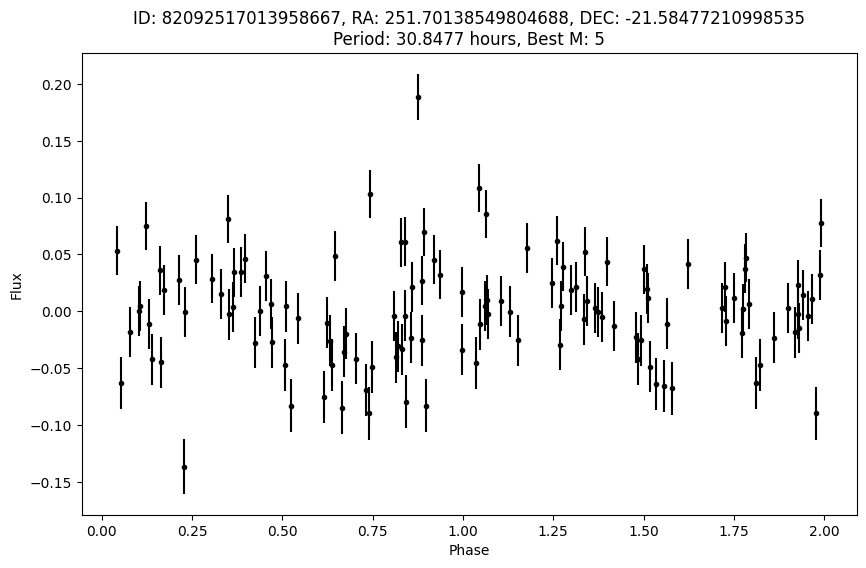

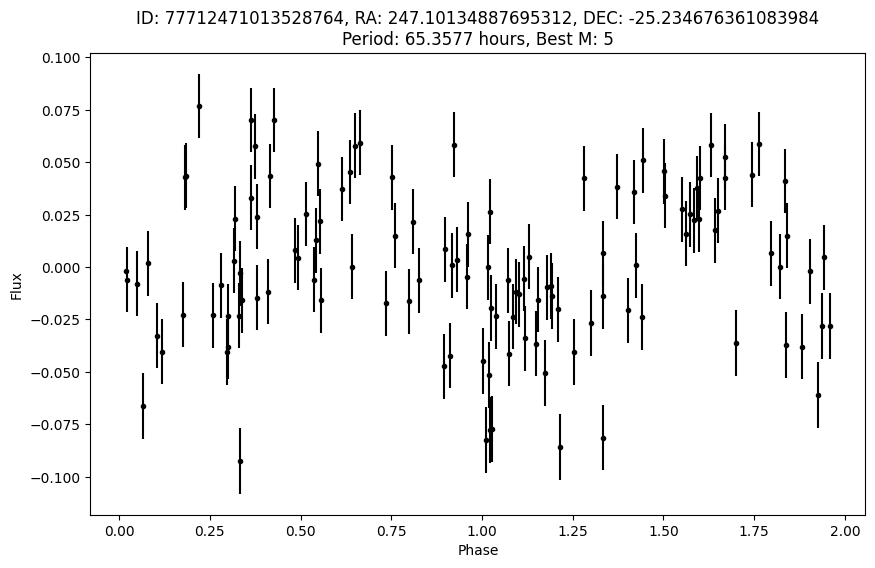

/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 501 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 501 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 501 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/swhitebook/miniconda3/envs/zvar/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 501 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


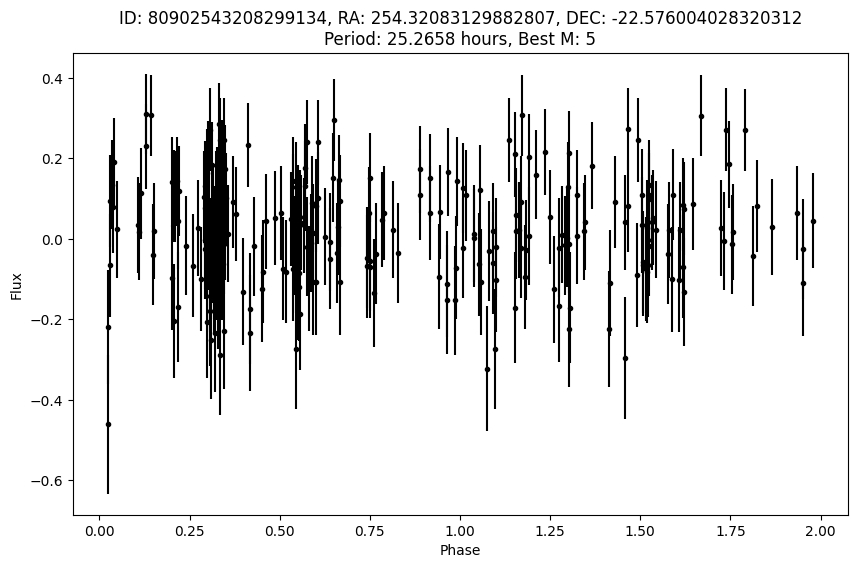

In [7]:


candidates = red_candidates
for candidate in candidates:
    result = query_kowalski(k, candidate.ra, candidate.dec, 50)
    if result is not None:
        barycorr_times, flux, ferrs = result
        times_days = barycorr_times / 86400
        phase = (times_days * candidate.freq) % 2

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.errorbar(phase, flux, yerr=ferrs, fmt='o', color='black', ms=3)
        ax.set_xlabel('Phase')
        ax.set_ylabel('Flux')
        ax.set_title(f'ID: {candidate.id}, RA: {candidate.ra}, DEC: {candidate.dec}\nPeriod: {24/candidate.freq:.4f} hours, Best M: {candidate.best_M}')
        plt.show()
    

Invidual Analysis

In [12]:
# ra = 358.8428039550781 
# dec = -26.302011489868164

ra = 4.303540229797363
dec = 32.12776565551758
min_epochs = 50

k = Kowalski(
    protocol="https",
    host="melman.caltech.edu",
    port=443,
    username="swhitebook",
    password="andromeda123",
    verbose=False,
    timeout=600,
)

barycorr_times, flux, ferrs = query_kowalski(k, ra, dec)

In [13]:
fgrid = freq_grid(barycorr_times)
# fgrid = fgrid[flag_terrestrial_freq(fgrid)]

ls_pgram = LombScargle(barycorr_times, flux, ferrs).power(fgrid)
fpw_pgram = fpw.run_fpw(barycorr_times, flux, ferrs, fgrid, 5)
fpw_pgram[np.isnan(fpw_pgram)] = 0

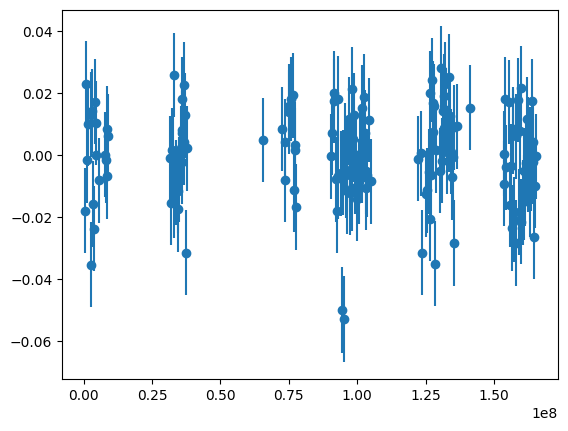

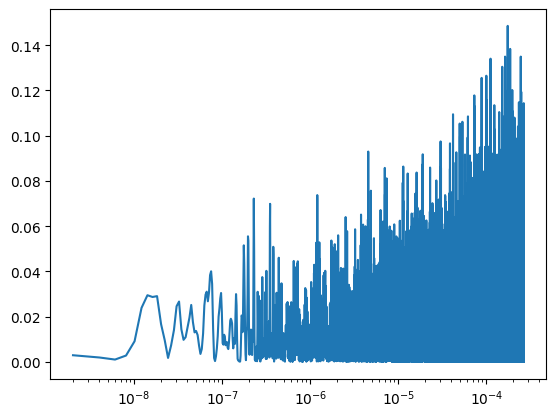

Best period: 1.4914028480706214 hours


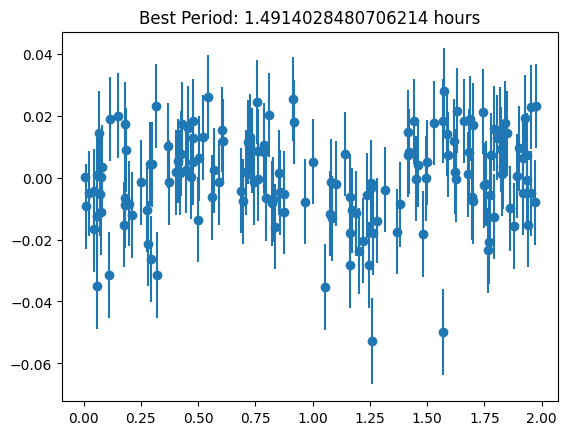

In [14]:
plt.figure()
plt.errorbar(barycorr_times, flux, yerr=ferrs, fmt='o')
plt.show()

plt.figure()
plt.plot(fgrid, ls_pgram)
# plt.plot(fgrid, fpw_pgram)
plt.xscale('log')
plt.show()

# best_period = 1/fgrid[np.argmax(ls_pgram)]
best_period = 1/fgrid[np.argmax(fpw_pgram)]
# best_period = 0.003954290821267756 * 86400
phase = (barycorr_times / best_period) % 2
print(f"Best period: {best_period / 60 / 60} hours")

plt.figure()
plt.errorbar(phase, flux, yerr=ferrs, fmt='o')
plt.title(f"Best Period: {best_period / 60 / 60} hours")
plt.show()